# <center> Проект: Предсказание рейтинга отеля по данным сайта Booking
   

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify # библиотека для упрощения создания диаграммы treemap
from sklearn import preprocessing
import category_encoders as ce

In [2]:
# Фиксируем сид для воспроизводимости кода
RANDOM_SEED = 17

In [3]:
# фиксируем версии пакетов
!pip freeze > requirements.txt

# Исследование структуры данных

1. Прочитайте данные с помощью библиотеки Pandas. Совет: перед чтением обратите внимание на разделитель внутри файла. 

In [4]:
# загрузка данных из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
# загрузка данных из соревнования

df_train = pd.read_csv('../data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('../data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('../data/submission.csv') # самбмишн

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [9]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_train, df_test], axis='index', ignore_index=True) # объединяем

Первоначальная версия датасета содержит 17 полей со следующей информацией:
* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [10]:
#проверка и ознакомление с данными
display(hotels.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,1


In [11]:
#размерность датасета и основная информация о столбцах
display(hotels.shape)
display(hotels.info())

(515738, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None

Данные содержат пропущенные значения в столбцах 'lat' и 'lng'
Числовые признаки содержатся в столбцах: 
* additional_number_of_scoring 
* average_score 
* review_total_negative_word_counts 
* total_number_of_reviews 
* review_total_positive_word_counts 
* total_number_of_reviews_reviewer_has_given 
* reviewer_score 
* lat 
* lng

Строковые признаки содержатся в столбцах: 
* hotel_address
* hotel_name
* reviewer_nationality 
* negative_review
* positive_review
* tags
* days_since_review

Признаки, представляющие дату:
* review_date

In [12]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


In [13]:
hotels.describe(include='all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
count,515738,515738.000000,515738,515738.000000,515738,515738,515738,515738.000000,515738.000000,515738,515738.000000,515738.000000,515738.000000,515738,515738,512470.000000,512470.000000,515738.000000
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,NaN,55242,731,NaN,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN,NaN
freq,4789,NaN,2585,NaN,4789,245246,127890,NaN,NaN,35946,NaN,NaN,NaN,5101,2585,NaN,NaN,NaN
mean,NaN,498.081836,NaN,8.397487,NaN,NaN,NaN,18.539450,2743.743944,NaN,17.776458,7.166001,6.297672,NaN,NaN,49.442439,2.823803,0.749999
std,NaN,500.538467,NaN,0.548048,NaN,NaN,NaN,29.690831,2317.464868,NaN,21.804185,11.040228,3.902295,NaN,NaN,3.466325,4.579425,0.433014
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,0.000000,NaN,NaN,41.328376,-0.369758,0.000000
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,0.625000,NaN,NaN,48.214662,-0.143372,0.250000
50%,NaN,341.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,7.900000,NaN,NaN,51.499981,0.010607,1.000000
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.000000,9.600000,NaN,NaN,51.516288,4.834443,1.000000


# Анализа, преобразование и проектирование признаков

### Проанализируем пропуски

In [14]:
# Создадим признаки 'no_lat' и 'no_lng' для пропущенных координат
hotels['no_lat'] = hotels.lat.isna()
hotels['no_lng'] = hotels.lng.isna()

# Изначально пропущенных координат одинаковое количество
# Проверим, у одних и тех ли отелей пропущены обе координаты
display(hotels[hotels['no_lat'] == True]['no_lng'].unique())
display(hotels[hotels['no_lng'] == True]['no_lat'].unique())

# Выясним, сколько отелей в датасете без координат
print('Всего адресов отелей:', hotels.hotel_address.nunique())
print('Всего обозначений долготы:', hotels.lng.nunique())
print('Всего обозначений широты:', hotels.lat.nunique())
print('Всего отелей без координат:', hotels[hotels.no_lat].hotel_address.nunique())

array([ True])

array([ True])

Всего адресов отелей: 1493
Всего обозначений долготы: 1472
Всего обозначений широты: 1472
Всего отелей без координат: 17


По анализу видно, что всего 1493 отеля, из которых 17 отелей без координат. При этом уникальных координат 1472, получается, что у 4 отелей координаты одинаковые.

### Заполним пропущенные координаты отелей
Источник данных: [Google Maps](www.google.com/maps)

In [15]:
# Запишем названия отелей 
hotels_names = hotels[hotels['no_lat']]['hotel_name'].value_counts()

hotels_no_lat_lng = {
    hotels_names.index[0]:[48.209495, 16.353446],
    hotels_names.index[1]:[48.214230, 16.380009],
    hotels_names.index[2]:[48.221847, 16.355896],
    hotels_names.index[3]:[48.875409, 2.323456],
    hotels_names.index[4]:[48.188972, 16.383811],
    hotels_names.index[5]:[48.216957, 16.359949],
    hotels_names.index[6]:[48.219691, 16.285571],
    hotels_names.index[7]:[41.391749, 2.177840],
    hotels_names.index[8]:[48.246066, 16.341822],
    hotels_names.index[9]:[48.221066, 16.366569],
    hotels_names.index[10]:[48.888909, 2.330578],
    hotels_names.index[11]:[48.220567, 16.215252],
    hotels_names.index[12]:[48.209663, 16.351442],
    hotels_names.index[13]:[48.187964, 16.420834],
    hotels_names.index[14]:[48.840061, 2.323586],
    hotels_names.index[15]:[41.383239, 2.160375],
    hotels_names.index[16]:[41.393776, 2.168609]
    }

In [16]:
# Для каждого города: [широта_достопримечательности, долгота_достопримечательности, наименование_достопримечательности]
# Данные взяты: https://dateandtime.info and Wiki in May 2023

cities_sights = {
    'Paris'    : [48.864804, 2.313812, 'Мост Александра III'], # выберем как центральную точку между Лувром, Эйфелевой башней и Триумфальной аркой
    'London'   : [51.514787, -0.098622, 'Собор Святого Павла'], # выберем как центральную точку между London Tower, британским музеем и Лондонским глазом
    'Barcelona': [41.389667, 2.185784, 'Парк Сьютаделья'], # выберем как точку, близкую к Дому Мила, Храму Святого Семейства и побережью
    'Milan'    : [45.467677, 9.189405, 'Оперный театр Ла Скала'], # выберем как точку, близкую к Галереи Виктора Эммануила II, Миланскому собору и Кастелло Сфорцеско
    'Vienna'   : [48.207514, 16.369456, 'Еврейский музей Вены'], # выберем как точку, близкую к Хофбургу и Собору Святого Стефана
    'Amsterdam': [52.365978, 4.902476, 'Эрмитаж Амстердама'], # выберем как точку, расположенную в центре с доступностью до Музея Ван Гога, Рейксмузея и музея Nemo
}

In [17]:
# временно заполним пустые значения координат отелей на 0
hotels['lat'] = hotels['lat'].fillna(0)
hotels['lng'] = hotels['lng'].fillna(0)

# Функция для заполнения широты, принимает название_адрес отеля и широту, возвращает обновленную широту
def get_lat(hotel_name, lat):
    if lat == 0:
        if hotel_name in hotels_no_lat_lng:
            lat = hotels_no_lat_lng[hotel_name][0]
    return lat

def get_lng(hotel_name, lng):
    if lng == 0:
        if hotel_name in hotels_no_lat_lng:
            lng = hotels_no_lat_lng[hotel_name][1]
    return lng

hotels['lat'] = hotels.apply(lambda x: get_lat(x['hotel_name'], x['lat']), axis=1)
hotels['lng'] = hotels.apply(lambda x: get_lng(x['hotel_name'], x['lng']), axis=1)

In [18]:
# удаляем лишние столбцы
hotels.drop(['no_lat', 'no_lng'], axis=1, inplace=True)

display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None

### Преобразование адреса

In [19]:
for address in hotels.hotel_address[:10]:
    print(address)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


In [20]:
hotels['country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))

hotels['city'] = hotels['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-1] != 'Kingdom' else x.split()[-5])


print('Всего стран в датасете: ', hotels['country'].nunique(), ' ', hotels['country'].unique())
print('Всего городов в датасете: ', hotels['city'].nunique(), ' ', hotels['city'].unique())

hotels = hotels.drop(['hotel_address'], axis=1)

Всего стран в датасете:  6   ['United Kingdom' 'France' 'Netherlands' 'Italy' 'Austria' 'Spain']
Всего городов в датасете:  6   ['London' 'Paris' 'Amsterdam' 'Milan' 'Vienna' 'Barcelona']


Городов в датасете немного, можно дополнительно использовать местоположение отелей и выяснить их близость к основным достопримечательностям

# <center> ПАРИЖ
<center> <img src = ../data/paris.png alt="drawing" style="width:900px;">

# <center> ЛОНДОН, АНГЛИЯ
<center> <img src = ../data/london.png alt="drawing" style="width:900px;">

# <center> БАРСЕЛОНА, ИСПАНИЯ
<center> <img src = ../data/barcelona.png alt="drawing" style="width:900px;">

# <center> МИЛАН, ИТАЛИЯ
<center> <img src = ../data/milan.png alt="drawing" style="width:900px;">

# <center> ВЕНА, АВСТРИЯ
<center> <img src = ../data/vienna.png alt="drawing" style="width:900px;">

# <center> АМСТЕРДАМ, НИДЕРЛАНДЫ
<center> <img src = ../data/amsterdam.png alt="drawing" style="width:900px;">

In [21]:
# Для каждого города: [радиус_города_км, широта_достопримечательности, долгота_достопримечательности, наименование_достопримечательности]
# Данные взяты: https://dateandtime.info and Wiki in May 2023

cities_sights = {
    'Paris'    : [5.8, 48.864804, 2.313812, 'Мост Александра III'], # выберем как центральную точку между Лувром, Эйфелевой башней и Триумфальной аркой
    'London'   : [22.6, 51.514787, -0.098622, 'Собор Святого Павла'], # выберем как центральную точку между London Tower, британским музеем и Лондонским глазом
    'Barcelona': [8.0, 41.389667, 2.185784, 'Парк Сьютаделья'], # выберем как точку, близкую к Дому Мила, Храму Святого Семейства и побережью
    'Milan'    : [7.6, 45.467677, 9.189405, 'Оперный театр Ла Скала'], # выберем как точку, близкую к Галереи Виктора Эммануила II, Миланскому собору и Кастелло Сфорцеско
    'Vienna'   : [11.5, 48.207514, 16.369456, 'Еврейский музей Вены'], # выберем как точку, близкую к Хофбургу и Собору Святого Стефана
    'Amsterdam': [8.8, 52.365978, 4.902476, 'Эрмитаж Амстердама'], # выберем как точку, расположенную в центре с доступностью до Музея Ван Гога, Рейксмузея и музея Nemo
}

Создаем новый столбец - расстояние до достопримечательностей.

$$ dist = \sqrt{(x_{b} - x_{a})^2 + (y_{b} - y_{a})^2} $$

Нужно будет перевести полученную дистанцию в километры, для этого воспользуемся матрицей длин дуги на 1° по широтам параллели

Источник данных: [Природа мира](https://natworld.info/nauki-o-prirode/kak-opredelit-rasstoyanie-s-pomoshhyu-gradusnoj-seti)

* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [22]:
# создаем столбец с расстояние от отеля до достопримечательностей

def get_dist(city, lat, lng):
    
    dist_to_km = {40: 85.4, 45: 78.8, 50: 71.7, 55: 64} # словарь приведения разницы долгот
    k_lat = 111.3 # константа перевода разницы широт в километры
    k_lng = 0 # объявляем переменную перевода разницы долгот в километры
    
    for key in dist_to_km.keys():
        if 0 < (cities_sights[city][1] - key) < 5:
            lat_lower = key
        if 0 < (key - cities_sights[city][1]) < 5:
            lat_upper = key
    
    k_lng = (dist_to_km[lat_upper] - dist_to_km[lat_lower]) * ((cities_sights[city][1] - lat_lower) / 5) + dist_to_km[lat_upper]
    
    return (((cities_sights[city][1] - lat)*k_lat)**2 + ((cities_sights[city][2] - lng)*k_lng)**2)**0.5

hotels['dist'] = hotels.apply(lambda x: get_dist(x.city, x.lat, x.lng), axis = 1)

In [23]:
# создаем столбец как отношение расстояния от отеля до достопримечательностей к радиусу города

hotels['proximity'] = hotels.apply(lambda x: x['dist']/cities_sights[x['city']][0], axis=1)

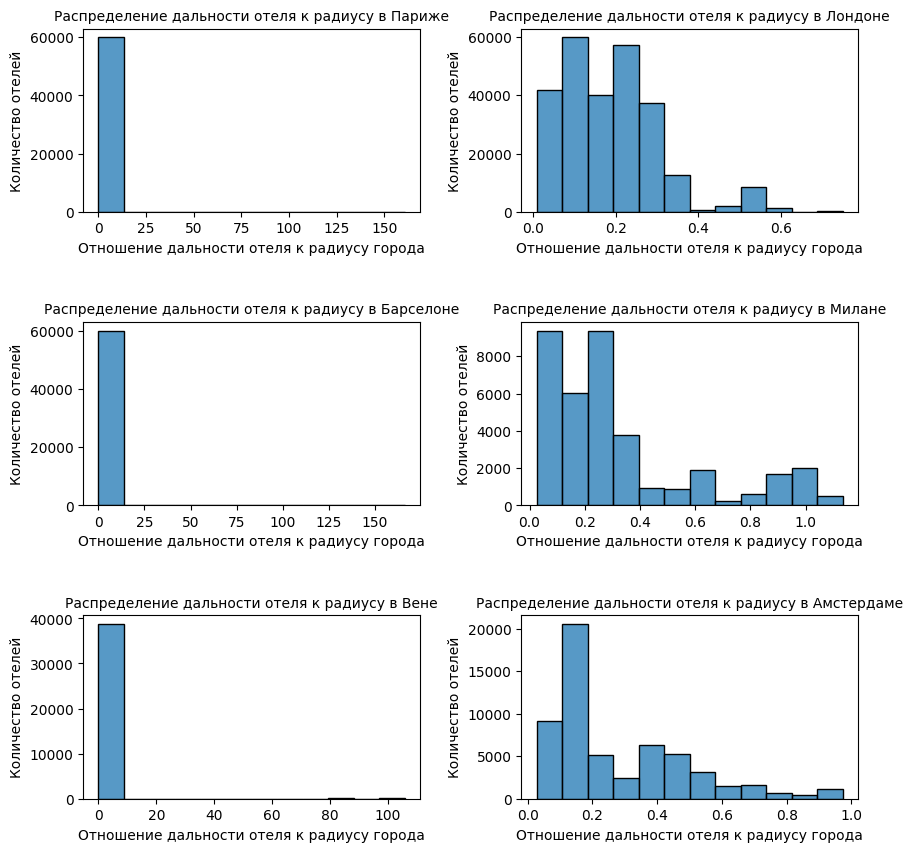

In [24]:
bins_number = 12
font = 10
x_label = 'Отношение дальности отеля к радиусу города'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=.6, wspace=.3)

histplot_par = sns.histplot(data=hotels[hotels.city == 'Paris'], 
                            x='proximity', bins=bins_number, ax=axes[0,0])
histplot_par.set_title('Распределение дальности отеля к радиусу в Париже', fontsize=font)
histplot_par.set_xlabel(x_label)
histplot_par.set_ylabel('Количество отелей')

histplot_lon = sns.histplot(data=hotels[hotels.city == 'London'],
                            x='proximity', bins=bins_number, ax=axes[0,1])
histplot_lon.set_title('Распределение дальности отеля к радиусу в Лондоне', fontsize=font)
histplot_lon.set_xlabel(x_label)
histplot_lon.set_ylabel('Количество отелей')

histplot_bar = sns.histplot(data=hotels[hotels.city == 'Barcelona'],
                            x='proximity', bins=bins_number, ax=axes[1,0])
histplot_bar.set_title('Распределение дальности отеля к радиусу в Барселоне', fontsize=font)
histplot_bar.set_xlabel(x_label)
histplot_bar.set_ylabel('Количество отелей')

histplot_mil = sns.histplot(data=hotels[hotels.city == 'Milan'],
                            x='proximity', bins=bins_number, ax=axes[1,1])
histplot_mil.set_title('Распределение дальности отеля к радиусу в Милане', fontsize=font)
histplot_mil.set_xlabel(x_label)
histplot_mil.set_ylabel('Количество отелей')

histplot_vie = sns.histplot(data=hotels[hotels.city == 'Vienna'],
                            x='proximity', bins=bins_number, ax=axes[2,0])
histplot_vie.set_title('Распределение дальности отеля к радиусу в Вене', fontsize=font)
histplot_vie.set_xlabel(x_label)
histplot_vie.set_ylabel('Количество отелей')

histplot_ams = sns.histplot(data=hotels[hotels.city == 'Amsterdam'],
                            x='proximity', bins=bins_number, ax=axes[2,1])
histplot_ams.set_title('Распределение дальности отеля к радиусу в Амстердаме', fontsize=font)
histplot_ams.set_xlabel(x_label)
histplot_ams.set_ylabel('Количество отелей');

In [25]:
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

None

### Анализ количества отзывов

In [26]:
hotels.total_number_of_reviews.describe()

count    515738.000000
mean       2743.743944
std        2317.464868
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3613.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

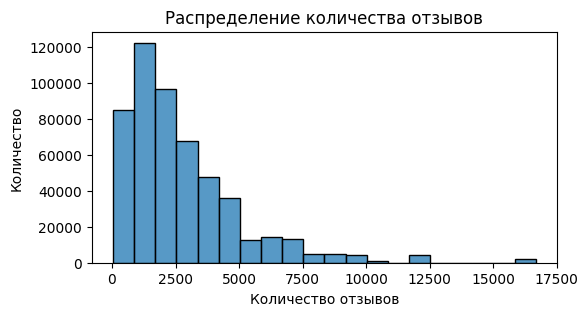

In [27]:
bins_number = 20
font = 12

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.subplots_adjust(hspace=.25)

histplot_par = sns.histplot(data=hotels, 
                            x='total_number_of_reviews', bins=bins_number)
histplot_par.set_title('Распределение количества отзывов', fontsize=font)
histplot_par.set_xlabel('Количество отзывов')
histplot_par.set_ylabel('Количество');

Не нормальное распределение, проверим логнормальность

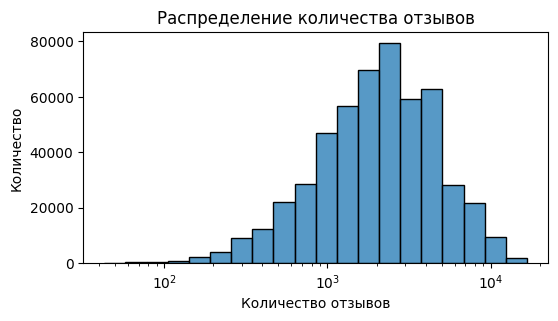

In [28]:
bins_number = 20
font = 12

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.subplots_adjust(hspace=.25)

histplot_par = sns.histplot(data=hotels, 
                            x='total_number_of_reviews', bins=bins_number, log_scale=True)
histplot_par.set_title('Распределение количества отзывов', fontsize=font)
histplot_par.set_xlabel('Количество отзывов')
histplot_par.set_ylabel('Количество');

Распределние близкое к логнормальному

### Анализ среднего балла по отзывам

In [29]:
hotels.average_score.describe()

count    515738.000000
mean          8.397487
std           0.548048
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

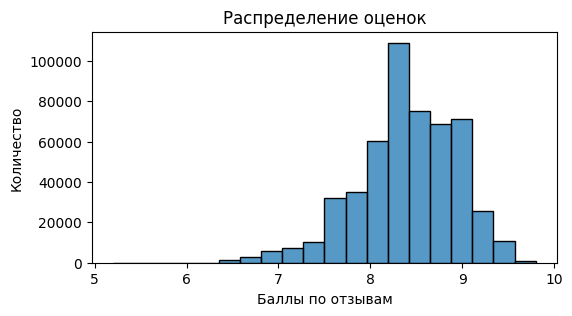

In [30]:
bins_number = 20
font = 12

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.subplots_adjust(hspace=.25)

histplot_par = sns.histplot(data=hotels, 
                            x='average_score', bins=bins_number)
histplot_par.set_title('Распределение оценок', fontsize=font)
histplot_par.set_xlabel('Баллы по отзывам')
histplot_par.set_ylabel('Количество');

Оценки ставят от 5 до 10 баллов, в основной массе 8-9 баллов

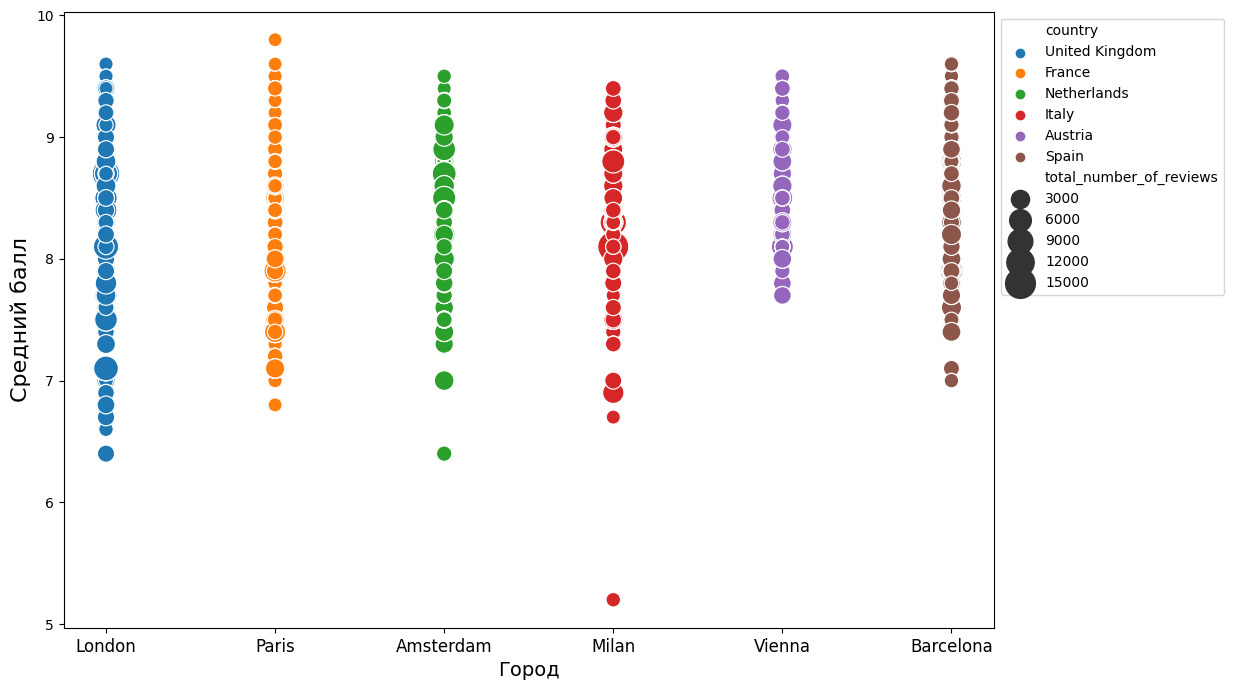

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

sns.scatterplot(data=hotels, 
                x='city',
                y='average_score',
                hue='country',
                size='total_number_of_reviews', 
                legend=True, sizes=(100, 500))

plt.xlabel('Город', fontsize=14)
plt.ylabel('Средний балл', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tick_params(axis='x', labelsize= 12 ) 

plt.show()

Из графика распределения видно, что в основном оценки ставят от 6,5 до 9,5

### Преобразование национальности рецензентов

In [32]:
display(hotels['reviewer_nationality'].nunique())
hotels['reviewer_nationality'].unique()

227

array([' United Kingdom ', ' China ', ' Poland ', ' France ',
       ' Switzerland ', ' Bulgaria ', ' Lebanon ',
       ' United Arab Emirates ', ' South Africa ', ' Nigeria ',
       ' Sweden ', ' United States of America ', ' Hong Kong ',
       ' Luxembourg ', ' Netherlands ', ' Jersey ', ' Pakistan ',
       ' Mexico ', ' Italy ', ' Singapore ', ' Ireland ', ' Kuwait ',
       ' Bahrain ', ' Portugal ', ' Canada ', ' Germany ', ' Oman ',
       ' Austria ', ' Japan ', ' Ukraine ', ' Finland ', ' Iran ',
       ' Thailand ', ' Brazil ', ' Denmark ', ' Australia ', ' Spain ',
       ' Gabon ', ' New Zealand ', ' Israel ', ' Cyprus ', ' Gibraltar ',
       ' Turkey ', ' Egypt ', ' Indonesia ', ' Slovakia ', ' Qatar ',
       ' Romania ', ' Belgium ', ' Trinidad and Tobago ', ' ',
       ' Saudi Arabia ', ' Bhutan ', ' Iceland ', ' Norway ',
       ' Sri Lanka ', ' Isle of Man ', ' Greece ', ' Slovenia ',
       ' Serbia ', ' Czech Republic ', ' Hungary ', ' Latvia ',
       ' Estonia 

В данных представлены рецензенты из 225 стран, данные содержат лишние пробелы в начале и в конце. Извлечем полезную информацию.

In [33]:
# добавляем резидента

hotels['reviewer_resident'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'][1:len(x['reviewer_nationality'])-1] == x['country'] else 0, axis=1)

hotels['reviewer_resident'].value_counts(normalize=True)

0    0.654082
1    0.345918
Name: reviewer_resident, dtype: float64

Около 1/3 отзывов отсавляют местные рецензенты

In [34]:
hotels['reviewer_nationality'].value_counts().nlargest(20).index

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada ', ' France ',
       ' Israel ', ' Italy ', ' Belgium ', ' Turkey ', ' Kuwait ', ' Spain ',
       ' Romania ', ' Russia ', ' South Africa '],
      dtype='object')

In [35]:
# оставим информацию о стране рецензентов, если отзывов больше 5 тысяч (топ-11)

top_reviewer_nationality = hotels['reviewer_nationality'].value_counts().nlargest(11).index

hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x[1:len(x)-1] if x in top_reviewer_nationality else 'Other')

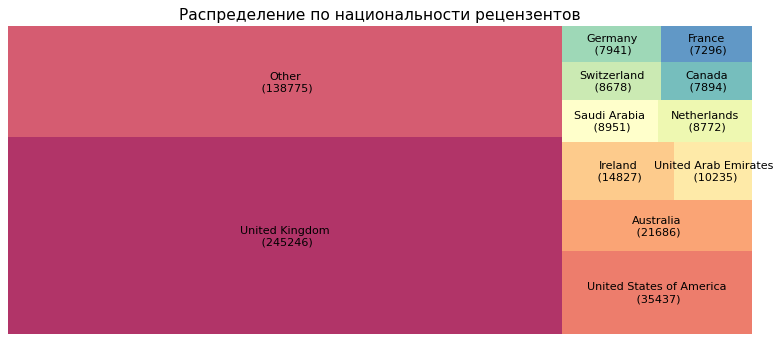

In [36]:
# функция создания диаграммы treemap
def creat_treemap(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    title_fontsize=14,   # title font size
    size=[8, 4]):        # size of the chart

    grouped = df.groupby(col).size().sort_values(ascending=False).reset_index(name='Counts')
    labels = grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = grouped['Counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

    plt.figure(figsize=(size[0], size[1]), dpi= 80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    plt.title(title, size=title_fontsize)
    plt.axis('off')
    plt.show();

creat_treemap(hotels, 'reviewer_nationality', 'Распределение по национальности рецензентов', size=[12, 5])

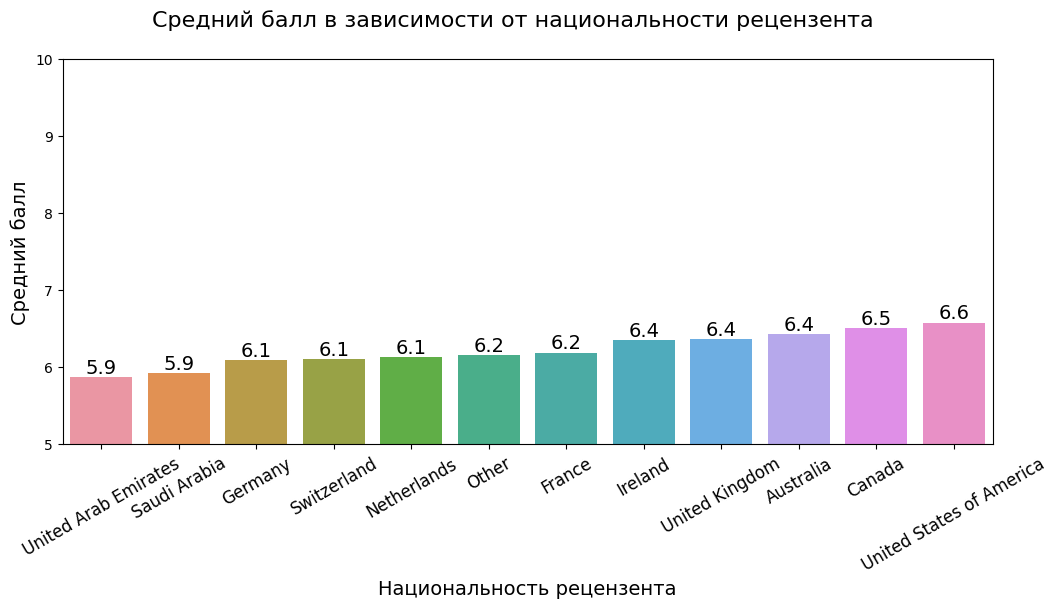

In [37]:
# функция создания столбчатой диаграммы

def create_barplot(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    xlabel,              # X axis label
    ylabel,              # Y axis label

    size=[10, 5],        # size of the chart
    ylim=[5, 7],         # min/max of Y axis

                         # font sizes of:
    title_fontsize=16,   # title
    ticks_fontsize=12,   # ticks
    xlabel_fontsize=14,  # X axis label
    xticks_rotation=0,   # xticks rotation 
    ylabel_fontsize=14): # Y axis label
    
    grouped = df.groupby(col)['reviewer_score'].agg(['mean']).sort_values('mean')

    fig, ax = plt.subplots(figsize=(size[0], size[1]))

    plt.suptitle(title, size=title_fontsize)
    bar_types = sns.barplot(x=grouped.index, y=grouped['mean'])

    for p in bar_types.patches:
        bar_types.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.4, p.get_height()),
        ha='center', va='bottom', fontsize=int((title_fontsize+ticks_fontsize)/2))

    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(xlabel, size=xlabel_fontsize)
    plt.ylabel(ylabel, size=ylabel_fontsize)
    plt.xticks(fontsize=ticks_fontsize)
    plt.xticks(rotation=xticks_rotation);
    
create_barplot(hotels, 'reviewer_nationality', 
                      'Средний балл в зависимости от национальности рецензента', 
                      'Национальность рецензента', 
                      'Средний балл', 
                      size=[12, 5], ylim=[5, 10], xticks_rotation=30)

### Преобразование тэгов

In [38]:
for tag in hotels.tags[:10]:
    print(tag)

[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']
[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']
[' Business trip ', ' Solo traveler ', ' Superior Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Double Room Non Smoking ', ' Stayed 1 night ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 4 nights ']
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Couple ', ' Twin Hilton Guest Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


In [39]:
hotels['tags'] = hotels['tags'].apply(lambda s: s[1:] if s[0] == '[' else s)
hotels['tags'] = hotels['tags'].apply(lambda s: s[:-1] if s[-1] == ']' else s)

hotels['tags'] = hotels['tags'].apply(lambda s: s.replace("' ", ""))
hotels['tags'] = hotels['tags'].apply(lambda s: s.replace(" '", ""))

hotels['tags_list'] = hotels['tags'].apply(lambda s: s.split(', '))

hotels['tags_count'] = hotels['tags_list'].apply(len)

hotels['tags_count'].value_counts(normalize=True)

5    0.577470
4    0.410216
3    0.010674
6    0.001464
2    0.000165
1    0.000012
Name: tags_count, dtype: float64

In [40]:
# создадим словарь тэгов, где тэги - ключи словаря, а значения - количество упоминаний тэга
dict_of_tags = dict()

for item in hotels['tags_list']:
    for tag in item:
        if tag in dict_of_tags.keys():
            dict_of_tags[tag] += 1
        else:
            dict_of_tags[tag] = 1
            
dict_of_tags

{'Leisure trip': 417778,
 'Couple': 252294,
 'Studio Suite': 728,
 'Stayed 2 nights': 133937,
 'Submitted from a mobile device': 307640,
 'Business trip': 82939,
 'Standard Double Room': 32248,
 'Stayed 1 night': 193645,
 'Solo traveler': 108545,
 'Modern Double Room Echo': 4,
 'Stayed 3 nights': 95821,
 'Standard Room with 1 Double Bed': 879,
 'Standard Double or Twin Room': 17483,
 'Stayed 6 nights': 9776,
 'Superior Twin Room': 6064,
 'Double Room Non Smoking': 1257,
 'Superior Double Room': 31393,
 'Stayed 4 nights': 47817,
 'Double Room': 35207,
 'Twin Hilton Guest Room': 951,
 'Family with young children': 61015,
 'Luxury Room': 308,
 'Double or Twin Room Non Smoking': 540,
 'Double or Twin Room': 22393,
 'Standard Room': 4205,
 'Group': 65392,
 'Comfort Double or Twin Room': 2404,
 'Standard': 1231,
 'Executive Double Room': 6425,
 'Twin Room Non Smoking': 700,
 'Studio Double Family': 506,
 'Double Twin Superior Room': 27,
 'X Ordinary Room': 89,
 '2 rooms': 12393,
 'King Delux

In [41]:
len(dict_of_tags.keys())

2428

Всего в датасете 2368 уникальных тэгов

In [42]:
max(dict_of_tags, key=dict_of_tags.get)

'Leisure trip'

Чаще всего в датасете встречается тэг Leisure trip

In [43]:
# выясним из тэгов, на сколько ночей чаще всего останавливаются
tags_stayed = dict()

for tag, value in dict_of_tags.items():
    if 'stayed' in tag.lower():
        tags_stayed[tag] = value

max(tags_stayed, key=tags_stayed.get)

'Stayed 1 night'

Чаще всего останавливаются на 1 ночь

In [44]:
dict_of_tags.keys()

dict_keys(['Leisure trip', 'Couple', 'Studio Suite', 'Stayed 2 nights', 'Submitted from a mobile device', 'Business trip', 'Standard Double Room', 'Stayed 1 night', 'Solo traveler', 'Modern Double Room Echo', 'Stayed 3 nights', 'Standard Room with 1 Double Bed', 'Standard Double or Twin Room', 'Stayed 6 nights', 'Superior Twin Room', 'Double Room Non Smoking', 'Superior Double Room', 'Stayed 4 nights', 'Double Room', 'Twin Hilton Guest Room', 'Family with young children', 'Luxury Room', 'Double or Twin Room Non Smoking', 'Double or Twin Room', 'Standard Room', 'Group', 'Comfort Double or Twin Room', 'Standard', 'Executive Double Room', 'Twin Room Non Smoking', 'Studio Double Family', 'Double Twin Superior Room', 'X Ordinary Room', '2 rooms', 'King Deluxe Guest Room', 'Double Studio', 'Family with older children', 'Luxury Double Room', 'Standard Double Room without Window', 'Hypoallergenic Double or Twin Room', 'Premier Double Room', 'Standard Room with Double Bed and Sofa Bed', 'Basic 

In [45]:
# есть тэги, обозначающие, на сколько ночей останавливаются
dict_of_stay = dict()
def get_nights_count(tags_list):
    for element in tags_list:
        if (element in dict_of_tags.keys()) and ('stayed' in element.lower()):
            dict_of_stay[element] = 1
            return element.split()[1]
    return 0

hotels['stay_any_nights'] = hotels['tags_list'].apply(get_nights_count)

# ограничим число вариантов
hotels['stay_any_nights'] = hotels['stay_any_nights'].apply(lambda x: x+' night(s)' if 0 < int(x) < 8 else 'Other')
hotels['stay_any_nights'].value_counts().nlargest(20)

1 night(s)    193645
2 night(s)    133937
3 night(s)     95821
4 night(s)     47817
5 night(s)     20845
6 night(s)      9776
7 night(s)      7399
Other           6498
Name: stay_any_nights, dtype: int64

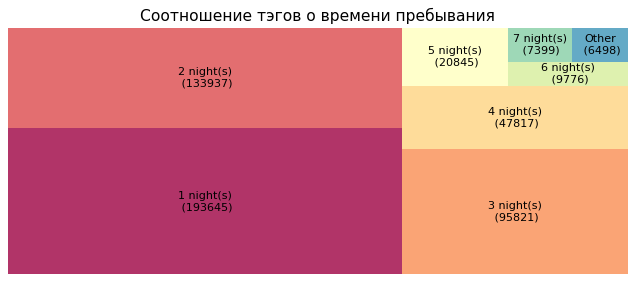

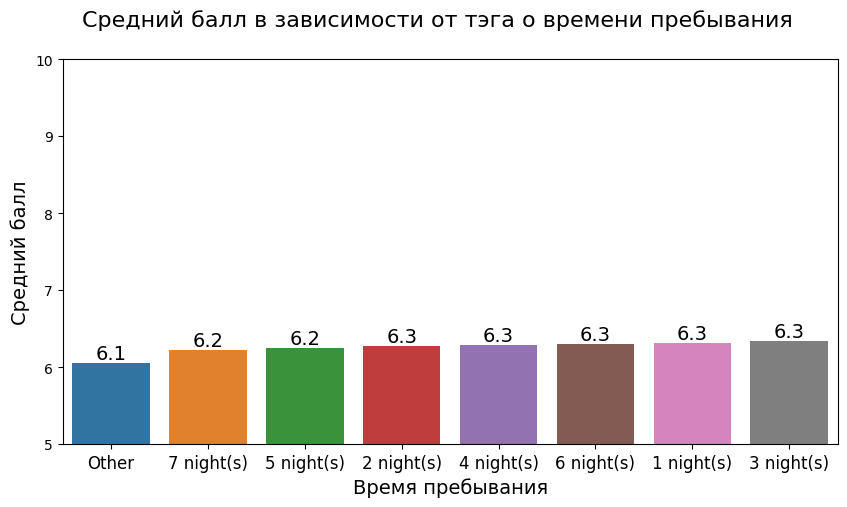

In [46]:
# строим диаграмму соотношения тэгов о времени пребывания
creat_treemap(hotels, 'stay_any_nights', 
                     'Соотношение тэгов о времени пребывания', size=[10, 4])

create_barplot(hotels, 'stay_any_nights', 
                      'Средний балл в зависимости от тэга о времени пребывания', 
                      'Время пребывания', 
                      'Средний балл', 
                      size=[10, 5], ylim=[5, 10])

In [47]:
for tag, value in dict_of_stay.items():
    dict_of_tags.pop(tag)
        
dict_of_tags.keys()

dict_keys(['Leisure trip', 'Couple', 'Studio Suite', 'Submitted from a mobile device', 'Business trip', 'Standard Double Room', 'Solo traveler', 'Modern Double Room Echo', 'Standard Room with 1 Double Bed', 'Standard Double or Twin Room', 'Superior Twin Room', 'Double Room Non Smoking', 'Superior Double Room', 'Double Room', 'Twin Hilton Guest Room', 'Family with young children', 'Luxury Room', 'Double or Twin Room Non Smoking', 'Double or Twin Room', 'Standard Room', 'Group', 'Comfort Double or Twin Room', 'Standard', 'Executive Double Room', 'Twin Room Non Smoking', 'Studio Double Family', 'Double Twin Superior Room', 'X Ordinary Room', '2 rooms', 'King Deluxe Guest Room', 'Double Studio', 'Family with older children', 'Luxury Double Room', 'Standard Double Room without Window', 'Hypoallergenic Double or Twin Room', 'Premier Double Room', 'Standard Room with Double Bed and Sofa Bed', 'Basic Double Room', 'Classic Double Room', 'Deluxe King Room', 'Superior Family Room', 'Double Guest

In [48]:
# есть тэги, обозначающие тип номера
dict_of_room = dict()
def get_room_type(tags_list):
    for element in tags_list:
        if (element in dict_of_tags.keys()) and (('room' in element.lower()) or ('standard' in element.lower()) or ('studio' in element.lower()) or ('apart' in element.lower()) \
        or ('suite' in element.lower()) or ('guestroom' in element.lower()) or ('deluxe' in element.lower()) or ('double' in element.lower()) \
        or ('superior' in element.lower()) or ('duplex' in element.lower()) or ('king' in element.lower()) or ('queen' in element.lower()) \
        or ('townhouse' in element.lower()) or ('maisonette' in element.lower()) or ('loft' in element.lower())or ('luxury four poster' in element.lower()) \
        or ('penthouse' in element.lower()) or ('view' in element.lower()) or ('cottage' in element.lower()) or ('вesig' in element.lower()) \
        or ('offer' in element.lower()) or ('atrium' in element.lower()) or ('twin' in element.lower()) or ('floor' in element.lower())):
            dict_of_room[element] = 1
            return element
    return '0'

hotels['room_type'] = hotels['tags_list'].apply(get_room_type)

# ограничим число вариантов
top_room_type = hotels['room_type'].value_counts().nlargest(7)
hotels['room_type'] = hotels['room_type'].apply(lambda x: x if (x in top_room_type) and (x != '0') else 'Other')
hotels['room_type'].value_counts()

Other                           335202
Double Room                      35207
Standard Double Room             32248
Superior Double Room             31393
Deluxe Double Room               24823
Double or Twin Room              22393
Standard Double or Twin Room     17483
Classic Double Room              16989
Name: room_type, dtype: int64

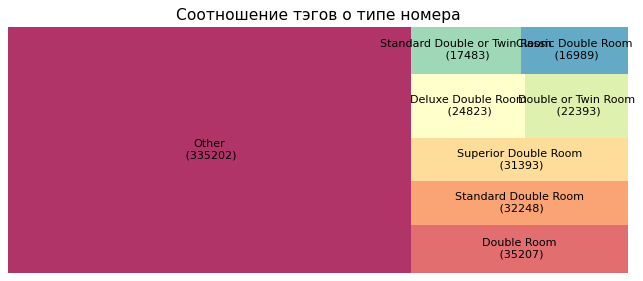

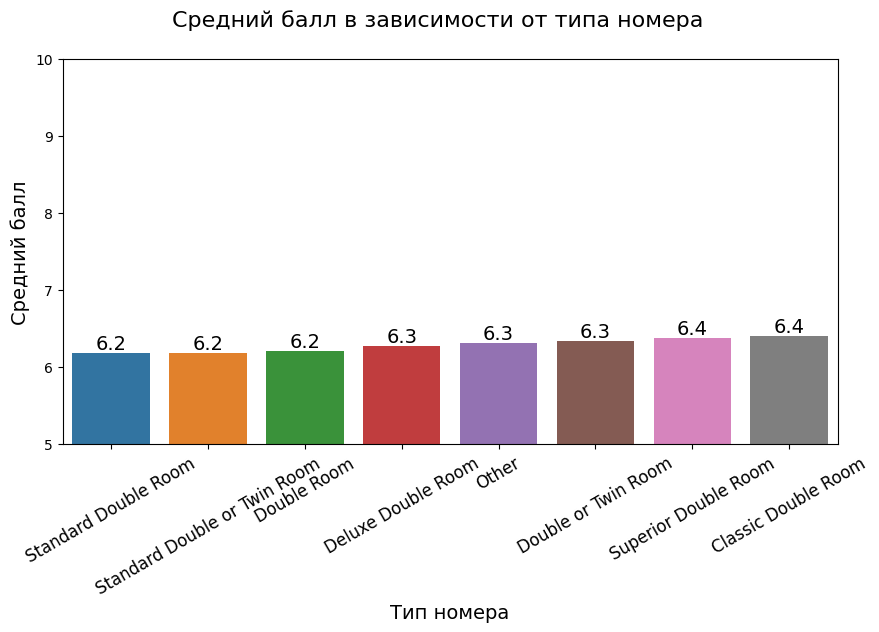

In [49]:
# строим диаграмму соотношения тэгов о типе номера

creat_treemap(hotels, 'room_type', 
                     'Соотношение тэгов о типе номера', size=[10, 4])

create_barplot(hotels, 'room_type', 
                      'Средний балл в зависимости от типа номера', 
                      'Тип номера', 
                      'Средний балл', 
                      size=[10, 5], ylim=[5, 10], xticks_rotation=30)

In [50]:
for tag, value in dict_of_room.items():
    dict_of_tags.pop(tag)
        
dict_of_tags.keys()

dict_keys(['Leisure trip', 'Couple', 'Submitted from a mobile device', 'Business trip', 'Solo traveler', 'Family with young children', 'Group', 'Family with older children', 'Travelers with friends', 'With a pet', 'Classic Designer', 'Classique Square', 'Cosy Family', 'Cool Corner Exchange', 'FAMILY PLAN', 'Fabulous Bank Canal', 'La Petite Maison', 'Premium Lafayette', 'The Rooks Nest'])

In [51]:
# есть тэги, обозначающие тип поездки
dict_of_travel_type = dict()
def get_travel_type(tags_list):
    for element in tags_list:
        if (element in dict_of_tags.keys()) and ('Solo' in element):
            dict_of_travel_type[element] = 1
            return 'Solo'
        elif (element in dict_of_tags.keys()) and (('Group' in element) or ('friends' in element)):
            dict_of_travel_type[element] = 1
            return 'Group'
        elif (element in dict_of_tags.keys()) and ('Couple' in element):
            dict_of_travel_type[element] = 1
            return 'Couple'
        elif (element in dict_of_tags.keys()) and ('Family' in element):
            dict_of_travel_type[element] = 1
            return 'Family'
    return 'Other'

hotels['travel_type'] = hotels['tags_list'].apply(get_travel_type)

hotels['travel_type'].value_counts()

Couple    252294
Solo      108545
Family     87364
Group      67535
Name: travel_type, dtype: int64

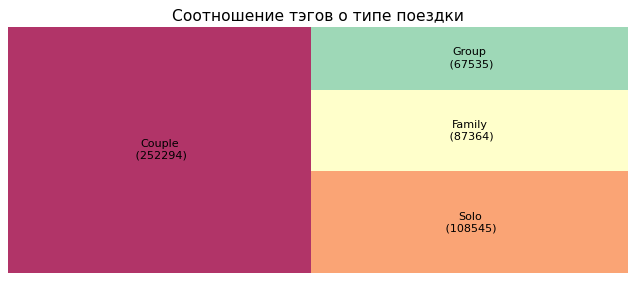

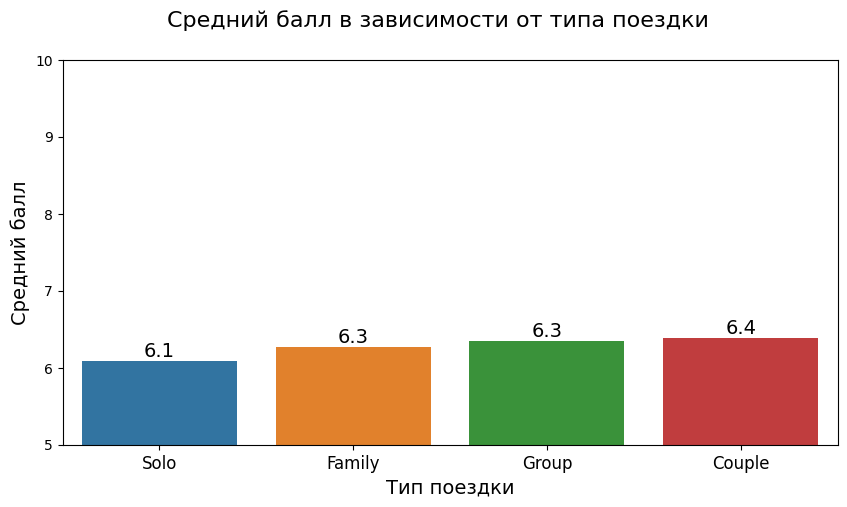

In [52]:
# строим диаграмму соотношения тэгов о типе поездки

creat_treemap(hotels, 'travel_type', 
                     'Соотношение тэгов о типе поездки', size=[10, 4])

create_barplot(hotels, 'travel_type', 
                      'Средний балл в зависимости от типа поездки', 
                      'Тип поездки', 
                      'Средний балл', 
                      size=[10, 5], ylim=[5, 10])

In [53]:
for tag, value in dict_of_travel_type.items():
    dict_of_tags.pop(tag)
        
dict_of_tags.keys()

dict_keys(['Leisure trip', 'Submitted from a mobile device', 'Business trip', 'With a pet', 'Classic Designer', 'Classique Square', 'Cosy Family', 'Cool Corner Exchange', 'FAMILY PLAN', 'Fabulous Bank Canal', 'La Petite Maison', 'Premium Lafayette', 'The Rooks Nest'])

In [54]:
# есть тэги, обозначающие тип визита
dict_of_visit_type = dict()
def get_visit_type(tags_list):
    for element in tags_list:
        if (element in dict_of_tags.keys()) and (element == 'Leisure trip'):
            dict_of_visit_type[element] = 1
            return element
        elif (element in dict_of_tags.keys()) and (element == 'Business trip'):
            dict_of_visit_type[element] = 1
            return element
    return 'Other'

hotels['visit_type'] = hotels['tags_list'].apply(get_visit_type)

hotels['visit_type'].value_counts()

Leisure trip     417778
Business trip     82939
Other             15021
Name: visit_type, dtype: int64

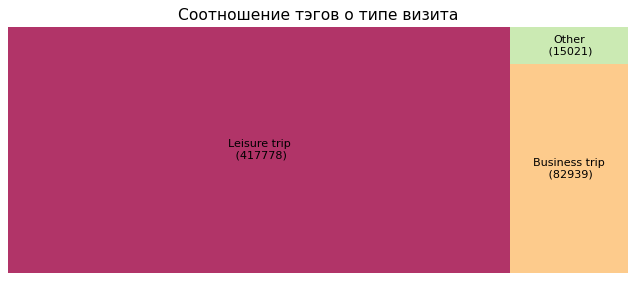

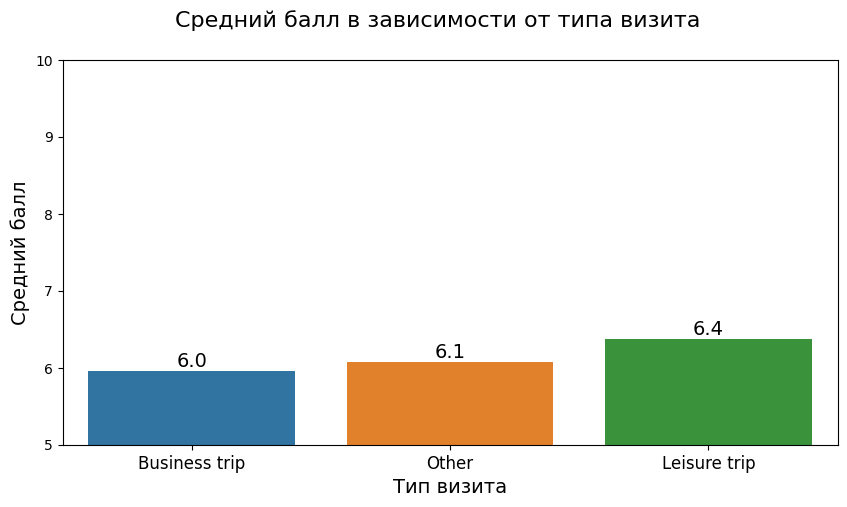

In [55]:
# строим диаграмму соотношения тэгов о типе визита

creat_treemap(hotels, 'visit_type', 
                     'Соотношение тэгов о типе визита', size=[10, 4])

create_barplot(hotels, 'visit_type', 
                      'Средний балл в зависимости от типа визита', 
                      'Тип визита', 
                      'Средний балл', 
                      size=[10, 5], ylim=[5, 10])

In [56]:
for tag, value in dict_of_visit_type.items():
    dict_of_tags.pop(tag)
        
dict_of_tags.keys()

dict_keys(['Submitted from a mobile device', 'With a pet', 'Classic Designer', 'Classique Square', 'Cosy Family', 'Cool Corner Exchange', 'FAMILY PLAN', 'Fabulous Bank Canal', 'La Petite Maison', 'Premium Lafayette', 'The Rooks Nest'])

In [57]:
# есть тэг, обозначающий возможность заселения с животными
dict_of_pet = dict()
def get_pet(tags_list):
    for element in tags_list:
        if (element in dict_of_tags.keys()) and (element == 'With a pet'):
            dict_of_pet[element] = 1
            return 1
    return 0

hotels['with_a_pet'] = hotels['tags_list'].apply(get_pet)

hotels['with_a_pet'].value_counts()

0    514333
1      1405
Name: with_a_pet, dtype: int64

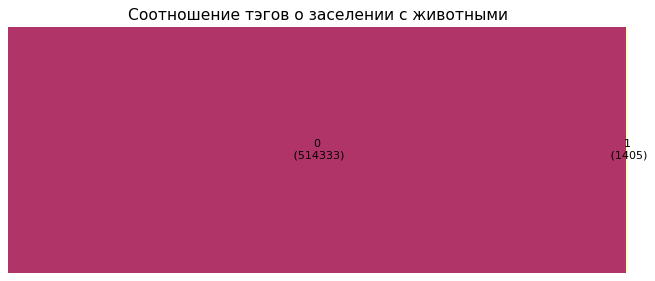

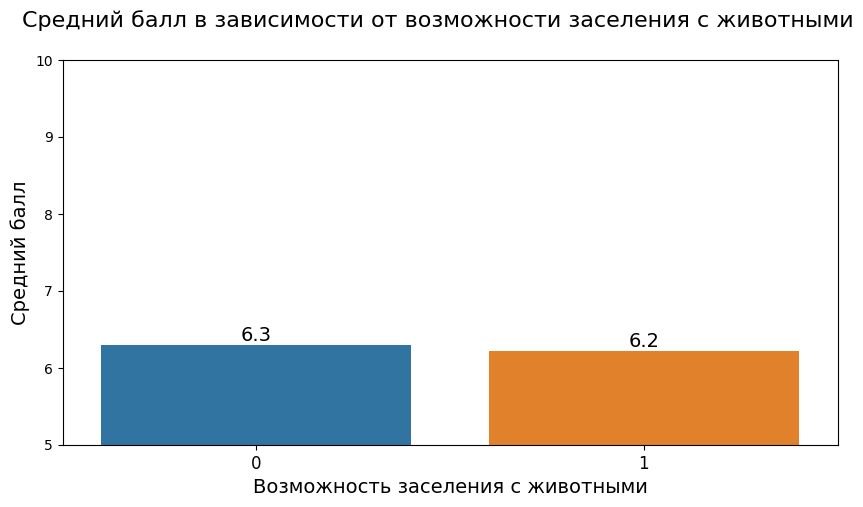

In [58]:
# строим диаграмму соотношения тэгов о возможности заселения с животными

creat_treemap(hotels, 'with_a_pet', 
                     'Соотношение тэгов о заселении с животными', size=[10, 4])

create_barplot(hotels, 'with_a_pet', 
                      'Средний балл в зависимости от возможности заселения с животными', 
                      'Возможность заселения с животными', 
                      'Средний балл', 
                      size=[10, 5], ylim=[5, 10])

In [59]:
for tag, value in dict_of_pet.items():
    dict_of_tags.pop(tag)
        
dict_of_tags.keys()

dict_keys(['Submitted from a mobile device', 'Classic Designer', 'Classique Square', 'Cosy Family', 'Cool Corner Exchange', 'FAMILY PLAN', 'Fabulous Bank Canal', 'La Petite Maison', 'Premium Lafayette', 'The Rooks Nest'])

In [60]:
# есть тэг, обозначающий отзывы с мобильного телефона
dict_of_mobile = dict()
def get_mobile(tags_list):
    for element in tags_list:
        if (element in dict_of_tags.keys()) and (element == 'Submitted from a mobile device'):
            dict_of_mobile[element] = 1
            return 1
    return 0

hotels['from_mobile'] = hotels['tags_list'].apply(get_mobile)

hotels['from_mobile'].value_counts()

1    307640
0    208098
Name: from_mobile, dtype: int64

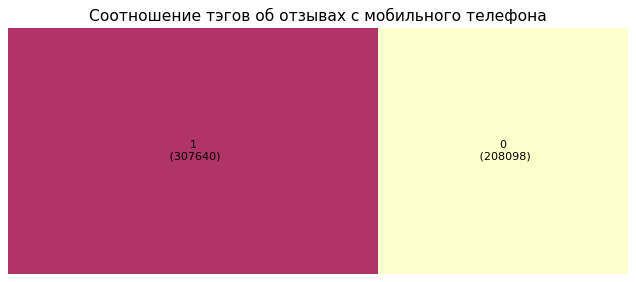

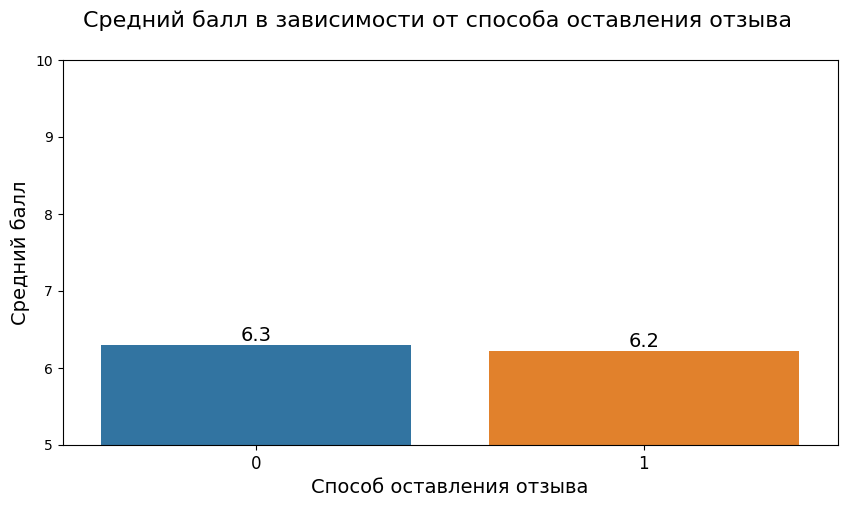

In [61]:
# строим диаграмму соотношения тэгов об отзывах с мобильного телефона

creat_treemap(hotels, 'from_mobile', 
                     'Соотношение тэгов об отзывах с мобильного телефона', size=[10, 4])

create_barplot(hotels, 'with_a_pet', 
                      'Средний балл в зависимости от способа оставления отзыва', 
                      'Способ оставления отзыва', 
                      'Средний балл', 
                      size=[10, 5], ylim=[5, 10])

In [62]:
for tag, value in dict_of_mobile.items():
    dict_of_tags.pop(tag)
        
dict_of_tags.keys()

dict_keys(['Classic Designer', 'Classique Square', 'Cosy Family', 'Cool Corner Exchange', 'FAMILY PLAN', 'Fabulous Bank Canal', 'La Petite Maison', 'Premium Lafayette', 'The Rooks Nest'])

In [63]:
dict_of_tags

{'Classic Designer': 22,
 'Classique Square': 27,
 'Cosy Family': 9,
 'Cool Corner Exchange': 3,
 'FAMILY PLAN': 1,
 'Fabulous Bank Canal': 2,
 'La Petite Maison': 4,
 'Premium Lafayette': 2,
 'The Rooks Nest': 2}

Оставшиеся тэги не отражают в достаточной для анализ мере своей сути, а число их мало, можно пренебречь.

In [64]:
# удаляем лишние столбцы
hotels = hotels.drop(['tags', 'tags_list'], axis = 1)

### Преобразуем дату отзыва

In [65]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.day
hotels['review_weekday'] = hotels['review_date'].dt.weekday + 1 # день недели

hotels = hotels.drop('review_date', axis=1)

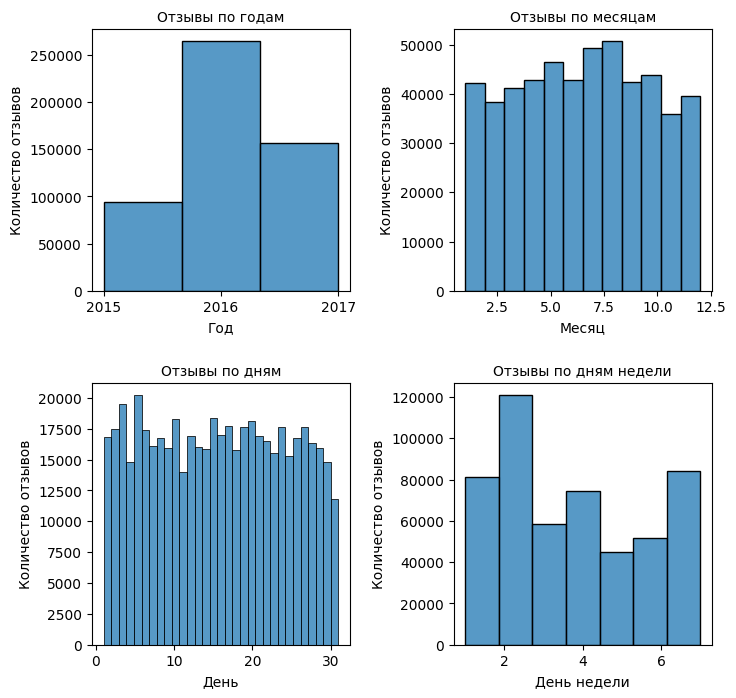

In [66]:
# построим диаграмму количество отзывов по данным из их даты

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
plt.subplots_adjust(hspace=.35, wspace=.4)

histplot1 = sns.histplot(data=hotels, x='review_year', bins=3, ax=axes[0,0])
histplot1.set_title('Отзывы по годам', fontsize=10)
histplot1.set_xlabel('Год')
histplot1.set_ylabel('Количество отзывов')
histplot1.set_xticks([2015,2016,2017])

histplot2 = sns.histplot(data=hotels, x='review_month', bins=12, ax=axes[0,1])
histplot2.set_title('Отзывы по месяцам', fontsize=10)
histplot2.set_xlabel('Месяц')
histplot2.set_ylabel('Количество отзывов')

histplot3 = sns.histplot(data=hotels, x='review_day', bins=31, ax=axes[1,0])
histplot3.set_title('Отзывы по дням', fontsize=10)
histplot3.set_xlabel('День')
histplot3.set_ylabel('Количество отзывов')

histplot3 = sns.histplot(data=hotels, x='review_weekday', bins=7, ax=axes[1,1])
histplot3.set_title('Отзывы по дням недели', fontsize=10)
histplot3.set_xlabel('День недели')
histplot3.set_ylabel('Количество отзывов');

Большинство отзывов оставлено в 2016 году. Обычно отзывы оставляют в летний период. Больше всего отзывов по вторникам, меньше всего - по пятницам.

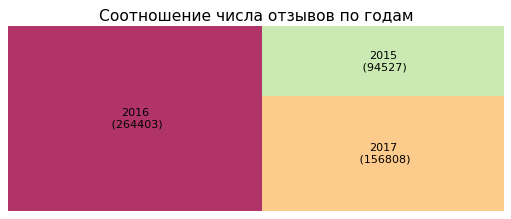

In [67]:
# строим диаграмму соотношения числа отзывов по годам

creat_treemap(hotels, 'review_year', 
                     'Соотношение числа отзывов по годам', size=[8, 3])

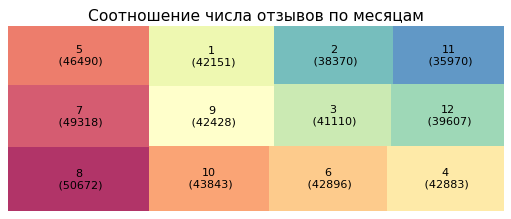

In [68]:
# строим диаграмму соотношения числа отзывов по месяцам

creat_treemap(hotels, 'review_month', 
                     'Соотношение числа отзывов по месяцам', size=[8, 3])

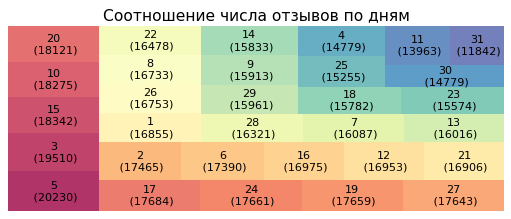

In [69]:
# строим диаграмму соотношения числа отзывов по дням

creat_treemap(hotels, 'review_day', 
                     'Соотношение числа отзывов по дням', size=[8, 3])

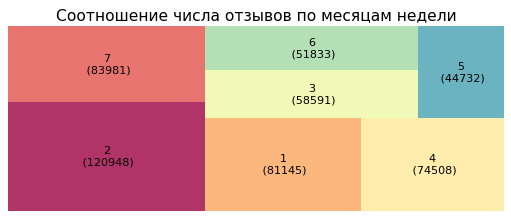

In [70]:
# строим диаграмму соотношения числа отзывов по дням недели

creat_treemap(hotels, 'review_weekday', 
                     'Соотношение числа отзывов по месяцам недели', size=[8, 3])

### Преобразуем число дней с даты отзыва

In [71]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

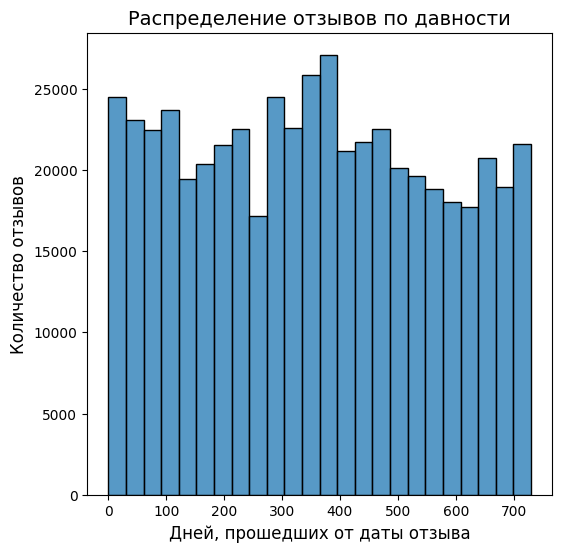

In [72]:
# построим диаграмму количество отзывов по данным из их даты

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
plt.subplots_adjust(hspace=.25)

histplot = sns.histplot(data=hotels, x='days_since_review', bins=24)
histplot.set_title('Распределение отзывов по давности', fontsize=14)
histplot.set_xlabel('Дней, прошедших от даты отзыва', fontsize=12)
histplot.set_ylabel('Количество отзывов', fontsize=12);

### Преобразуем признаки формулировок отзывов и количества слов в отзывах

In [73]:
# удаляем начальные и конечные пробелы в признаке негативных отзывов
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip())

In [74]:
hotels['negative_review'].value_counts().reset_index().head(25)

,index,negative_review
0,No Negative,127890
1,Nothing,18531
2,nothing,2508
3,None,1166
4,N A,1060
5,,849
6,Nothing really,570
7,N a,520
8,All good,470
9,Small room,455


In [75]:
# введем обозначение для неотрицательных отзывов
positive = ['No Negative', '', 'None', 'N A', '', 'N a', 'none', 'n a', 'Can t think of anything', 'NA', 'No', 'Na', 'Non', 'Not applicable', 'No negatives', 'Not a thing', 
            'No thing', 'No issues', 'no', 'No problems', 'All ok', 'No bad experience', 'Nada', 'non', 'No bad experiences', 'Couldn t fault it', 
            'Cannot think of anything', 'I can t think of anything', 'Everything was ok']

hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if x in positive else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'nothin' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'love' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'good' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'perfect' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'great' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'excellent' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'like' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'complai' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'fine' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'comment' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Positive' if 'nil' in x.lower() else x)

In [76]:
# введем обозначение для средне-отрицательных отзывов

little_negative = ['See above', 'Not much', 'As above']

hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if x in little_negative else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'breakfast' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'room' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'location' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'expensive' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'price' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'small' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'staff' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'parking' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'gym' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'wifi' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'bed' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'pool' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'bar' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'cost' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'view' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'service' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'nois' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'pillow' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'cleanliness' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'food' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'money' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'bath' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'lift' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'shower' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'facilities' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'condi' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'restaurant' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'housekeep' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'kettle' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'old' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'internet' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'elevator' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Little Negative' if 'fridge' in x.lower() else x)

In [77]:
# введем обозначение для плохих отзывов

hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Bad' if 'everything' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Bad' if 'leav' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Bad' if 'all' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Bad' if 'longer' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Bad' if 'home' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Bad' if 'everything' in x.lower() else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Bad' if 'bad' in x.lower() else x)

In [78]:
# остальные отзывы пометим как "прочие"
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'Other' if (x != 'Positive') and (x != 'Little Negative') and (x != 'Bad') else x)

hotels['negative_review'].value_counts().reset_index()

,index,negative_review
0,Little Negative,236370
1,Positive,232434
2,Other,38381
3,Bad,8553


In [79]:
# удаляем начальные и конечные пробелы в признаке позитивных отзывов
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip())

In [80]:
hotels['positive_review'].value_counts().reset_index().head(25)

,index,positive_review
0,No Positive,35946
1,Location,10137
2,Everything,2897
3,location,1736
4,Nothing,1468
5,Great location,1419
6,The location,1341
7,Good location,1203
8,Breakfast,664
9,Friendly staff,603


In [81]:
# введем обозначение для неположительных отзывов

positive = ['No Positive', '']

hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Bad' if x in positive else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Bad' if 'nothin' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Bad' if 'nil' in x.lower() else x)

In [82]:
# введем обозначение для средне-положительных отзывов

little_negative = ['See above', 'Not much', 'As above']

hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if x in little_negative else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'breakfast' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'room' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'location' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'expensive' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'price' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'small' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'staff' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'parking' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'gym' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'wifi' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'bed' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'pool' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'bar' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'cost' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'view' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'service' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'nois' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'pillow' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'cleanliness' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'food' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'money' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'bath' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'lift' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'shower' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'facilities' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'condi' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'restaurant' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'housekeep' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'kettle' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'old' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'internet' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'elevator' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Little Positive' if 'fridge' in x.lower() else x)	

In [83]:
# введем обозначение для хороших отзывов

hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Good' if 'everything' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Good' if 'all' in x.lower() else x)
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Good' if 'everything' in x.lower() else x)

In [84]:
# остальные отзывы пометим как "прочие"
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'Other' if (x != 'Bad') and (x != 'Little Positive') and (x != 'Good') else x)

hotels['positive_review'].value_counts().reset_index()

,index,positive_review
0,Little Positive,414492
1,Other,43951
2,Bad,42775
3,Good,14520


In [85]:
hotels['negative_review'].value_counts().reset_index()

,index,negative_review
0,Little Negative,236370
1,Positive,232434
2,Other,38381
3,Bad,8553


In [86]:
# преобразуем отзывы в баллы

def get_positive_score(review):
    if review == 'Bad':
        score = -1
    elif review == 'Little Positive':
        score = 1
    elif review == 'Good':
        score = 2
    else:
        score = 0
    return score

def get_negative_score(review):
    if review == 'Positive':
        score = 1
    elif review == 'Little Negative':
        score = -1
    elif review == 'Bad':
        score = -2
    else:
        score = 0
    return score

hotels['positive_score'] = hotels['positive_review'].apply(get_positive_score)
hotels['negative_score'] = hotels['negative_review'].apply(get_negative_score)

In [87]:
# нормализуем новые признаки баллов по отзывам

data_positive_score_mm = preprocessing.MinMaxScaler().fit_transform(hotels[['positive_score']])
data_negative_score_mm = preprocessing.MinMaxScaler().fit_transform(hotels[['negative_score']])

# преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_positive_score_mm = pd.DataFrame(data_positive_score_mm, columns=['positive_score_mm'])
data_negative_score_mm = pd.DataFrame(data_negative_score_mm, columns=['negative_score_mm'])

# посмотреть результаты
#display(data_positive_score_mm, data_negative_score_mm)

# добавляем к основному датасету
hotels = pd.concat([hotels, data_positive_score_mm], axis=1)
hotels = pd.concat([hotels, data_negative_score_mm], axis=1)


In [88]:
# соединим эти показатели в один - разностный
hotels['review_score_delta'] = hotels['positive_score_mm'] - hotels['negative_score_mm']

In [89]:
# нормализуем признаки количества слов по отзывам

data_total_positive_word_mm = preprocessing.MinMaxScaler().fit_transform(hotels[['review_total_positive_word_counts']])
data_total_negative_word_mm = preprocessing.MinMaxScaler().fit_transform(hotels[['review_total_negative_word_counts']])

# преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_total_positive_word_mm = pd.DataFrame(data_total_positive_word_mm, columns=['review_total_positive_word_counts_mm'])
data_total_negative_word_mm = pd.DataFrame(data_total_negative_word_mm, columns=['review_total_negative_word_counts_mm'])

# посмотреть результаты
#display(data_positive_score_mm, data_negative_score_mm)

# добавляем к основному датасету
hotels = pd.concat([hotels, data_total_positive_word_mm], axis=1)
hotels = pd.concat([hotels, data_total_negative_word_mm], axis=1)

In [90]:
# соединим эти показатели в один - разностный
hotels['review_total_word_delta'] = hotels['review_total_positive_word_counts_mm'] - hotels['review_total_negative_word_counts_mm']

In [91]:
# создадим результирующий признак по отзывам
# это будет разность хороших и плохих отзывов, к которой для увеличения акцента добавим разность в количестве слов хороших и плохих отзывов
hotels['review_total_score'] = hotels['review_score_delta'] + hotels['review_total_word_delta']

In [92]:
# нормализуем новый результирующий признак по отзывам

data_total_score_mm = preprocessing.MinMaxScaler().fit_transform(hotels[['review_total_score']])

# преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_total_score_mm = pd.DataFrame(data_total_score_mm, columns=['review_total_score_mm'])

# посмотреть результаты
#display(data_positive_score_mm, data_negative_score_mm)

# добавляем к основному датасету
hotels = pd.concat([hotels, data_total_score_mm], axis=1)

In [93]:
hotels['review_total_score_mm'].describe()

count    515738.000000
mean          0.542569
std           0.103814
min           0.000000
25%           0.470102
50%           0.525784
75%           0.648413
max           1.000000
Name: review_total_score_mm, dtype: float64

In [94]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

### Преобразование признака количества отзывов рецензентов

In [95]:
# вычисляем долю рецензий рецензентом от общего числа отзывов в датасете
hotels['ratio_of_review'] = hotels['total_number_of_reviews_reviewer_has_given'] / hotels['total_number_of_reviews']

# логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента
hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x + 1))

hotels['ratio_of_review']

0         0.003511
1         0.010287
2         0.034483
3         0.013180
4         0.001318
            ...   
515733    0.014228
515734    0.001912
515735    0.000289
515736    0.006648
515737    0.000349
Name: ratio_of_review, Length: 515738, dtype: float64

# Очистка и выбор признаков

In [96]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 

In [97]:
# проанализируем мультиколинеарность признаков

heat_df = hotels.copy() # создаем копию датафрейма

heat_df = heat_df.drop('hotel_name', axis=1) # удалим название отелей

In [98]:
heat_df['reviewer_nationality'].describe()

count             515738
unique                12
top       United Kingdom
freq              245246
Name: reviewer_nationality, dtype: object

In [99]:
# закодируем признаки

data_reviewer_nationality = heat_df.copy()

ord_encoder = ce.OrdinalEncoder(cols=['reviewer_nationality']) #Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder
reviewer_nationality_col = ord_encoder.fit_transform(data_reviewer_nationality[['reviewer_nationality']]) #Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними
heat_df = pd.concat([heat_df, reviewer_nationality_col], axis=1) #Затем используем метод concat() для добавления закодированного признака в датафрейм data.

heat_df

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,positive_score_mm,negative_score_mm,review_score_delta,review_total_positive_word_counts_mm,review_total_negative_word_counts_mm,review_total_word_delta,review_total_score,review_total_score_mm,ratio_of_review,reviewer_nationality
0,581,8.4,United Kingdom,Bad,3,1994,Little Positive,4,2.079442,10.0,...,0.666667,0.000000,0.666667,0.010127,0.007353,0.002774,0.669440,0.748581,0.003511,1
1,299,8.3,United Kingdom,Little Negative,3,1361,Little Positive,2,2.708050,6.3,...,0.666667,0.333333,0.333333,0.005063,0.007353,-0.002290,0.331044,0.653160,0.010287,1
2,32,8.9,Other,Little Negative,6,406,Bad,0,2.708050,7.5,...,0.000000,0.333333,-0.333333,0.000000,0.014706,-0.014706,-0.348039,0.461672,0.034483,2
3,34,7.5,United Kingdom,Positive,0,607,Little Positive,11,2.197225,10.0,...,0.666667,1.000000,-0.333333,0.027848,0.000000,0.027848,-0.305485,0.473672,0.013180,1
4,914,8.5,Other,Other,4,7586,Little Positive,20,2.397895,9.6,...,0.666667,0.666667,0.000000,0.050633,0.009804,0.040829,0.040829,0.571325,0.001318,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.1,Other,Positive,0,984,Little Positive,4,2.708050,0.0,...,0.666667,1.000000,-0.333333,0.010127,0.000000,0.010127,-0.323207,0.468674,0.014228,2
515734,46,7.8,United States of America,Positive,0,523,Little Positive,24,0.693147,0.0,...,0.666667,1.000000,-0.333333,0.060759,0.000000,0.060759,-0.272574,0.482952,0.001912,6
515735,260,8.0,Other,Little Negative,31,3461,Little Positive,23,0.693147,0.0,...,0.666667,0.333333,0.333333,0.058228,0.075980,-0.017753,0.315581,0.648799,0.000289,2
515736,159,9.0,Australia,Positive,0,1053,Little Positive,20,2.079442,0.0,...,0.666667,1.000000,-0.333333,0.050633,0.000000,0.050633,-0.282700,0.480096,0.006648,11


In [100]:
# закодируем признаки

data_country = heat_df.copy()

ord_encoder = ce.OrdinalEncoder(cols=['country']) #Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder
country_col = ord_encoder.fit_transform(data_country[['country']]) #Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними
heat_df = pd.concat([heat_df, country_col], axis=1) #Затем используем метод concat() для добавления закодированного признака в датафрейм data.

heat_df

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,negative_score_mm,review_score_delta,review_total_positive_word_counts_mm,review_total_negative_word_counts_mm,review_total_word_delta,review_total_score,review_total_score_mm,ratio_of_review,reviewer_nationality,country
0,581,8.4,United Kingdom,Bad,3,1994,Little Positive,4,2.079442,10.0,...,0.000000,0.666667,0.010127,0.007353,0.002774,0.669440,0.748581,0.003511,1,1
1,299,8.3,United Kingdom,Little Negative,3,1361,Little Positive,2,2.708050,6.3,...,0.333333,0.333333,0.005063,0.007353,-0.002290,0.331044,0.653160,0.010287,1,1
2,32,8.9,Other,Little Negative,6,406,Bad,0,2.708050,7.5,...,0.333333,-0.333333,0.000000,0.014706,-0.014706,-0.348039,0.461672,0.034483,2,2
3,34,7.5,United Kingdom,Positive,0,607,Little Positive,11,2.197225,10.0,...,1.000000,-0.333333,0.027848,0.000000,0.027848,-0.305485,0.473672,0.013180,1,2
4,914,8.5,Other,Other,4,7586,Little Positive,20,2.397895,9.6,...,0.666667,0.000000,0.050633,0.009804,0.040829,0.040829,0.571325,0.001318,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.1,Other,Positive,0,984,Little Positive,4,2.708050,0.0,...,1.000000,-0.333333,0.010127,0.000000,0.010127,-0.323207,0.468674,0.014228,2,4
515734,46,7.8,United States of America,Positive,0,523,Little Positive,24,0.693147,0.0,...,1.000000,-0.333333,0.060759,0.000000,0.060759,-0.272574,0.482952,0.001912,6,6
515735,260,8.0,Other,Little Negative,31,3461,Little Positive,23,0.693147,0.0,...,0.333333,0.333333,0.058228,0.075980,-0.017753,0.315581,0.648799,0.000289,2,5
515736,159,9.0,Australia,Positive,0,1053,Little Positive,20,2.079442,0.0,...,1.000000,-0.333333,0.050633,0.000000,0.050633,-0.282700,0.480096,0.006648,11,4


In [101]:
# закодируем признаки

data_city = heat_df.copy()

ord_encoder = ce.OrdinalEncoder(cols=['city']) #Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder
city_col = ord_encoder.fit_transform(data_city[['city']]) #Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними
heat_df = pd.concat([heat_df, city_col], axis=1) #Затем используем метод concat() для добавления закодированного признака в датафрейм data.

heat_df

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,review_score_delta,review_total_positive_word_counts_mm,review_total_negative_word_counts_mm,review_total_word_delta,review_total_score,review_total_score_mm,ratio_of_review,reviewer_nationality,country,city
0,581,8.4,United Kingdom,Bad,3,1994,Little Positive,4,2.079442,10.0,...,0.666667,0.010127,0.007353,0.002774,0.669440,0.748581,0.003511,1,1,1
1,299,8.3,United Kingdom,Little Negative,3,1361,Little Positive,2,2.708050,6.3,...,0.333333,0.005063,0.007353,-0.002290,0.331044,0.653160,0.010287,1,1,1
2,32,8.9,Other,Little Negative,6,406,Bad,0,2.708050,7.5,...,-0.333333,0.000000,0.014706,-0.014706,-0.348039,0.461672,0.034483,2,2,2
3,34,7.5,United Kingdom,Positive,0,607,Little Positive,11,2.197225,10.0,...,-0.333333,0.027848,0.000000,0.027848,-0.305485,0.473672,0.013180,1,2,2
4,914,8.5,Other,Other,4,7586,Little Positive,20,2.397895,9.6,...,0.000000,0.050633,0.009804,0.040829,0.040829,0.571325,0.001318,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.1,Other,Positive,0,984,Little Positive,4,2.708050,0.0,...,-0.333333,0.010127,0.000000,0.010127,-0.323207,0.468674,0.014228,2,4,4
515734,46,7.8,United States of America,Positive,0,523,Little Positive,24,0.693147,0.0,...,-0.333333,0.060759,0.000000,0.060759,-0.272574,0.482952,0.001912,6,6,6
515735,260,8.0,Other,Little Negative,31,3461,Little Positive,23,0.693147,0.0,...,0.333333,0.058228,0.075980,-0.017753,0.315581,0.648799,0.000289,2,5,5
515736,159,9.0,Australia,Positive,0,1053,Little Positive,20,2.079442,0.0,...,-0.333333,0.050633,0.000000,0.050633,-0.282700,0.480096,0.006648,11,4,4


In [102]:
# закодируем признаки

data_stay_any_nights = heat_df.copy()

ord_encoder = ce.OrdinalEncoder(cols=['stay_any_nights']) #Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder
stay_any_nights_col = ord_encoder.fit_transform(data_stay_any_nights[['stay_any_nights']]) #Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними
heat_df = pd.concat([heat_df, stay_any_nights_col], axis=1) #Затем используем метод concat() для добавления закодированного признака в датафрейм data.

heat_df

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,review_total_positive_word_counts_mm,review_total_negative_word_counts_mm,review_total_word_delta,review_total_score,review_total_score_mm,ratio_of_review,reviewer_nationality,country,city,stay_any_nights
0,581,8.4,United Kingdom,Bad,3,1994,Little Positive,4,2.079442,10.0,...,0.010127,0.007353,0.002774,0.669440,0.748581,0.003511,1,1,1,1
1,299,8.3,United Kingdom,Little Negative,3,1361,Little Positive,2,2.708050,6.3,...,0.005063,0.007353,-0.002290,0.331044,0.653160,0.010287,1,1,1,2
2,32,8.9,Other,Little Negative,6,406,Bad,0,2.708050,7.5,...,0.000000,0.014706,-0.014706,-0.348039,0.461672,0.034483,2,2,2,3
3,34,7.5,United Kingdom,Positive,0,607,Little Positive,11,2.197225,10.0,...,0.027848,0.000000,0.027848,-0.305485,0.473672,0.013180,1,2,2,2
4,914,8.5,Other,Other,4,7586,Little Positive,20,2.397895,9.6,...,0.050633,0.009804,0.040829,0.040829,0.571325,0.001318,2,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.1,Other,Positive,0,984,Little Positive,4,2.708050,0.0,...,0.010127,0.000000,0.010127,-0.323207,0.468674,0.014228,2,4,4,5
515734,46,7.8,United States of America,Positive,0,523,Little Positive,24,0.693147,0.0,...,0.060759,0.000000,0.060759,-0.272574,0.482952,0.001912,6,6,6,1
515735,260,8.0,Other,Little Negative,31,3461,Little Positive,23,0.693147,0.0,...,0.058228,0.075980,-0.017753,0.315581,0.648799,0.000289,2,5,5,1
515736,159,9.0,Australia,Positive,0,1053,Little Positive,20,2.079442,0.0,...,0.050633,0.000000,0.050633,-0.282700,0.480096,0.006648,11,4,4,3


In [103]:
# закодируем признаки

data_room_type = heat_df.copy()

ord_encoder = ce.OrdinalEncoder(cols=['room_type']) #Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder
room_type_col = ord_encoder.fit_transform(data_room_type[['room_type']]) #Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними
heat_df = pd.concat([heat_df, room_type_col], axis=1) #Затем используем метод concat() для добавления закодированного признака в датафрейм data.

heat_df

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,review_total_negative_word_counts_mm,review_total_word_delta,review_total_score,review_total_score_mm,ratio_of_review,reviewer_nationality,country,city,stay_any_nights,room_type
0,581,8.4,United Kingdom,Bad,3,1994,Little Positive,4,2.079442,10.0,...,0.007353,0.002774,0.669440,0.748581,0.003511,1,1,1,1,1
1,299,8.3,United Kingdom,Little Negative,3,1361,Little Positive,2,2.708050,6.3,...,0.007353,-0.002290,0.331044,0.653160,0.010287,1,1,1,2,2
2,32,8.9,Other,Little Negative,6,406,Bad,0,2.708050,7.5,...,0.014706,-0.014706,-0.348039,0.461672,0.034483,2,2,2,3,1
3,34,7.5,United Kingdom,Positive,0,607,Little Positive,11,2.197225,10.0,...,0.000000,0.027848,-0.305485,0.473672,0.013180,1,2,2,2,1
4,914,8.5,Other,Other,4,7586,Little Positive,20,2.397895,9.6,...,0.009804,0.040829,0.040829,0.571325,0.001318,2,3,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.1,Other,Positive,0,984,Little Positive,4,2.708050,0.0,...,0.000000,0.010127,-0.323207,0.468674,0.014228,2,4,4,5,5
515734,46,7.8,United States of America,Positive,0,523,Little Positive,24,0.693147,0.0,...,0.000000,0.060759,-0.272574,0.482952,0.001912,6,6,6,1,5
515735,260,8.0,Other,Little Negative,31,3461,Little Positive,23,0.693147,0.0,...,0.075980,-0.017753,0.315581,0.648799,0.000289,2,5,5,1,1
515736,159,9.0,Australia,Positive,0,1053,Little Positive,20,2.079442,0.0,...,0.000000,0.050633,-0.282700,0.480096,0.006648,11,4,4,3,1


In [104]:
# закодируем признаки

data_travel_type = heat_df.copy()

ord_encoder = ce.OrdinalEncoder(cols=['travel_type']) #Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder
travel_type_col = ord_encoder.fit_transform(data_travel_type[['travel_type']]) #Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними
heat_df = pd.concat([heat_df, travel_type_col], axis=1) #Затем используем метод concat() для добавления закодированного признака в датафрейм data.

heat_df

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,review_total_word_delta,review_total_score,review_total_score_mm,ratio_of_review,reviewer_nationality,country,city,stay_any_nights,room_type,travel_type
0,581,8.4,United Kingdom,Bad,3,1994,Little Positive,4,2.079442,10.0,...,0.002774,0.669440,0.748581,0.003511,1,1,1,1,1,1
1,299,8.3,United Kingdom,Little Negative,3,1361,Little Positive,2,2.708050,6.3,...,-0.002290,0.331044,0.653160,0.010287,1,1,1,2,2,1
2,32,8.9,Other,Little Negative,6,406,Bad,0,2.708050,7.5,...,-0.014706,-0.348039,0.461672,0.034483,2,2,2,3,1,2
3,34,7.5,United Kingdom,Positive,0,607,Little Positive,11,2.197225,10.0,...,0.027848,-0.305485,0.473672,0.013180,1,2,2,2,1,2
4,914,8.5,Other,Other,4,7586,Little Positive,20,2.397895,9.6,...,0.040829,0.040829,0.571325,0.001318,2,3,3,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.1,Other,Positive,0,984,Little Positive,4,2.708050,0.0,...,0.010127,-0.323207,0.468674,0.014228,2,4,4,5,5,1
515734,46,7.8,United States of America,Positive,0,523,Little Positive,24,0.693147,0.0,...,0.060759,-0.272574,0.482952,0.001912,6,6,6,1,5,1
515735,260,8.0,Other,Little Negative,31,3461,Little Positive,23,0.693147,0.0,...,-0.017753,0.315581,0.648799,0.000289,2,5,5,1,1,2
515736,159,9.0,Australia,Positive,0,1053,Little Positive,20,2.079442,0.0,...,0.050633,-0.282700,0.480096,0.006648,11,4,4,3,1,2


In [105]:
# закодируем признаки

data_visit_type = heat_df.copy()

ord_encoder = ce.OrdinalEncoder(cols=['visit_type']) #Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder
visit_type_col = ord_encoder.fit_transform(data_visit_type[['visit_type']]) #Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними
heat_df = pd.concat([heat_df, visit_type_col], axis=1) #Затем используем метод concat() для добавления закодированного признака в датафрейм data.

heat_df

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,review_total_score,review_total_score_mm,ratio_of_review,reviewer_nationality,country,city,stay_any_nights,room_type,travel_type,visit_type
0,581,8.4,United Kingdom,Bad,3,1994,Little Positive,4,2.079442,10.0,...,0.669440,0.748581,0.003511,1,1,1,1,1,1,1
1,299,8.3,United Kingdom,Little Negative,3,1361,Little Positive,2,2.708050,6.3,...,0.331044,0.653160,0.010287,1,1,1,2,2,1,2
2,32,8.9,Other,Little Negative,6,406,Bad,0,2.708050,7.5,...,-0.348039,0.461672,0.034483,2,2,2,3,1,2,1
3,34,7.5,United Kingdom,Positive,0,607,Little Positive,11,2.197225,10.0,...,-0.305485,0.473672,0.013180,1,2,2,2,1,2,1
4,914,8.5,Other,Other,4,7586,Little Positive,20,2.397895,9.6,...,0.040829,0.571325,0.001318,2,3,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,53,8.1,Other,Positive,0,984,Little Positive,4,2.708050,0.0,...,-0.323207,0.468674,0.014228,2,4,4,5,5,1,2
515734,46,7.8,United States of America,Positive,0,523,Little Positive,24,0.693147,0.0,...,-0.272574,0.482952,0.001912,6,6,6,1,5,1,1
515735,260,8.0,Other,Little Negative,31,3461,Little Positive,23,0.693147,0.0,...,0.315581,0.648799,0.000289,2,5,5,1,1,2,2
515736,159,9.0,Australia,Positive,0,1053,Little Positive,20,2.079442,0.0,...,-0.282700,0.480096,0.006648,11,4,4,3,1,2,1


#### Построение тепловой карты корреляции признаков

C:\Users\Sl1mka\AppData\Local\Temp\ipykernel_7348\1890015596.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = heat_df.drop(['reviewer_score'], axis=1).corr(method='spearman')


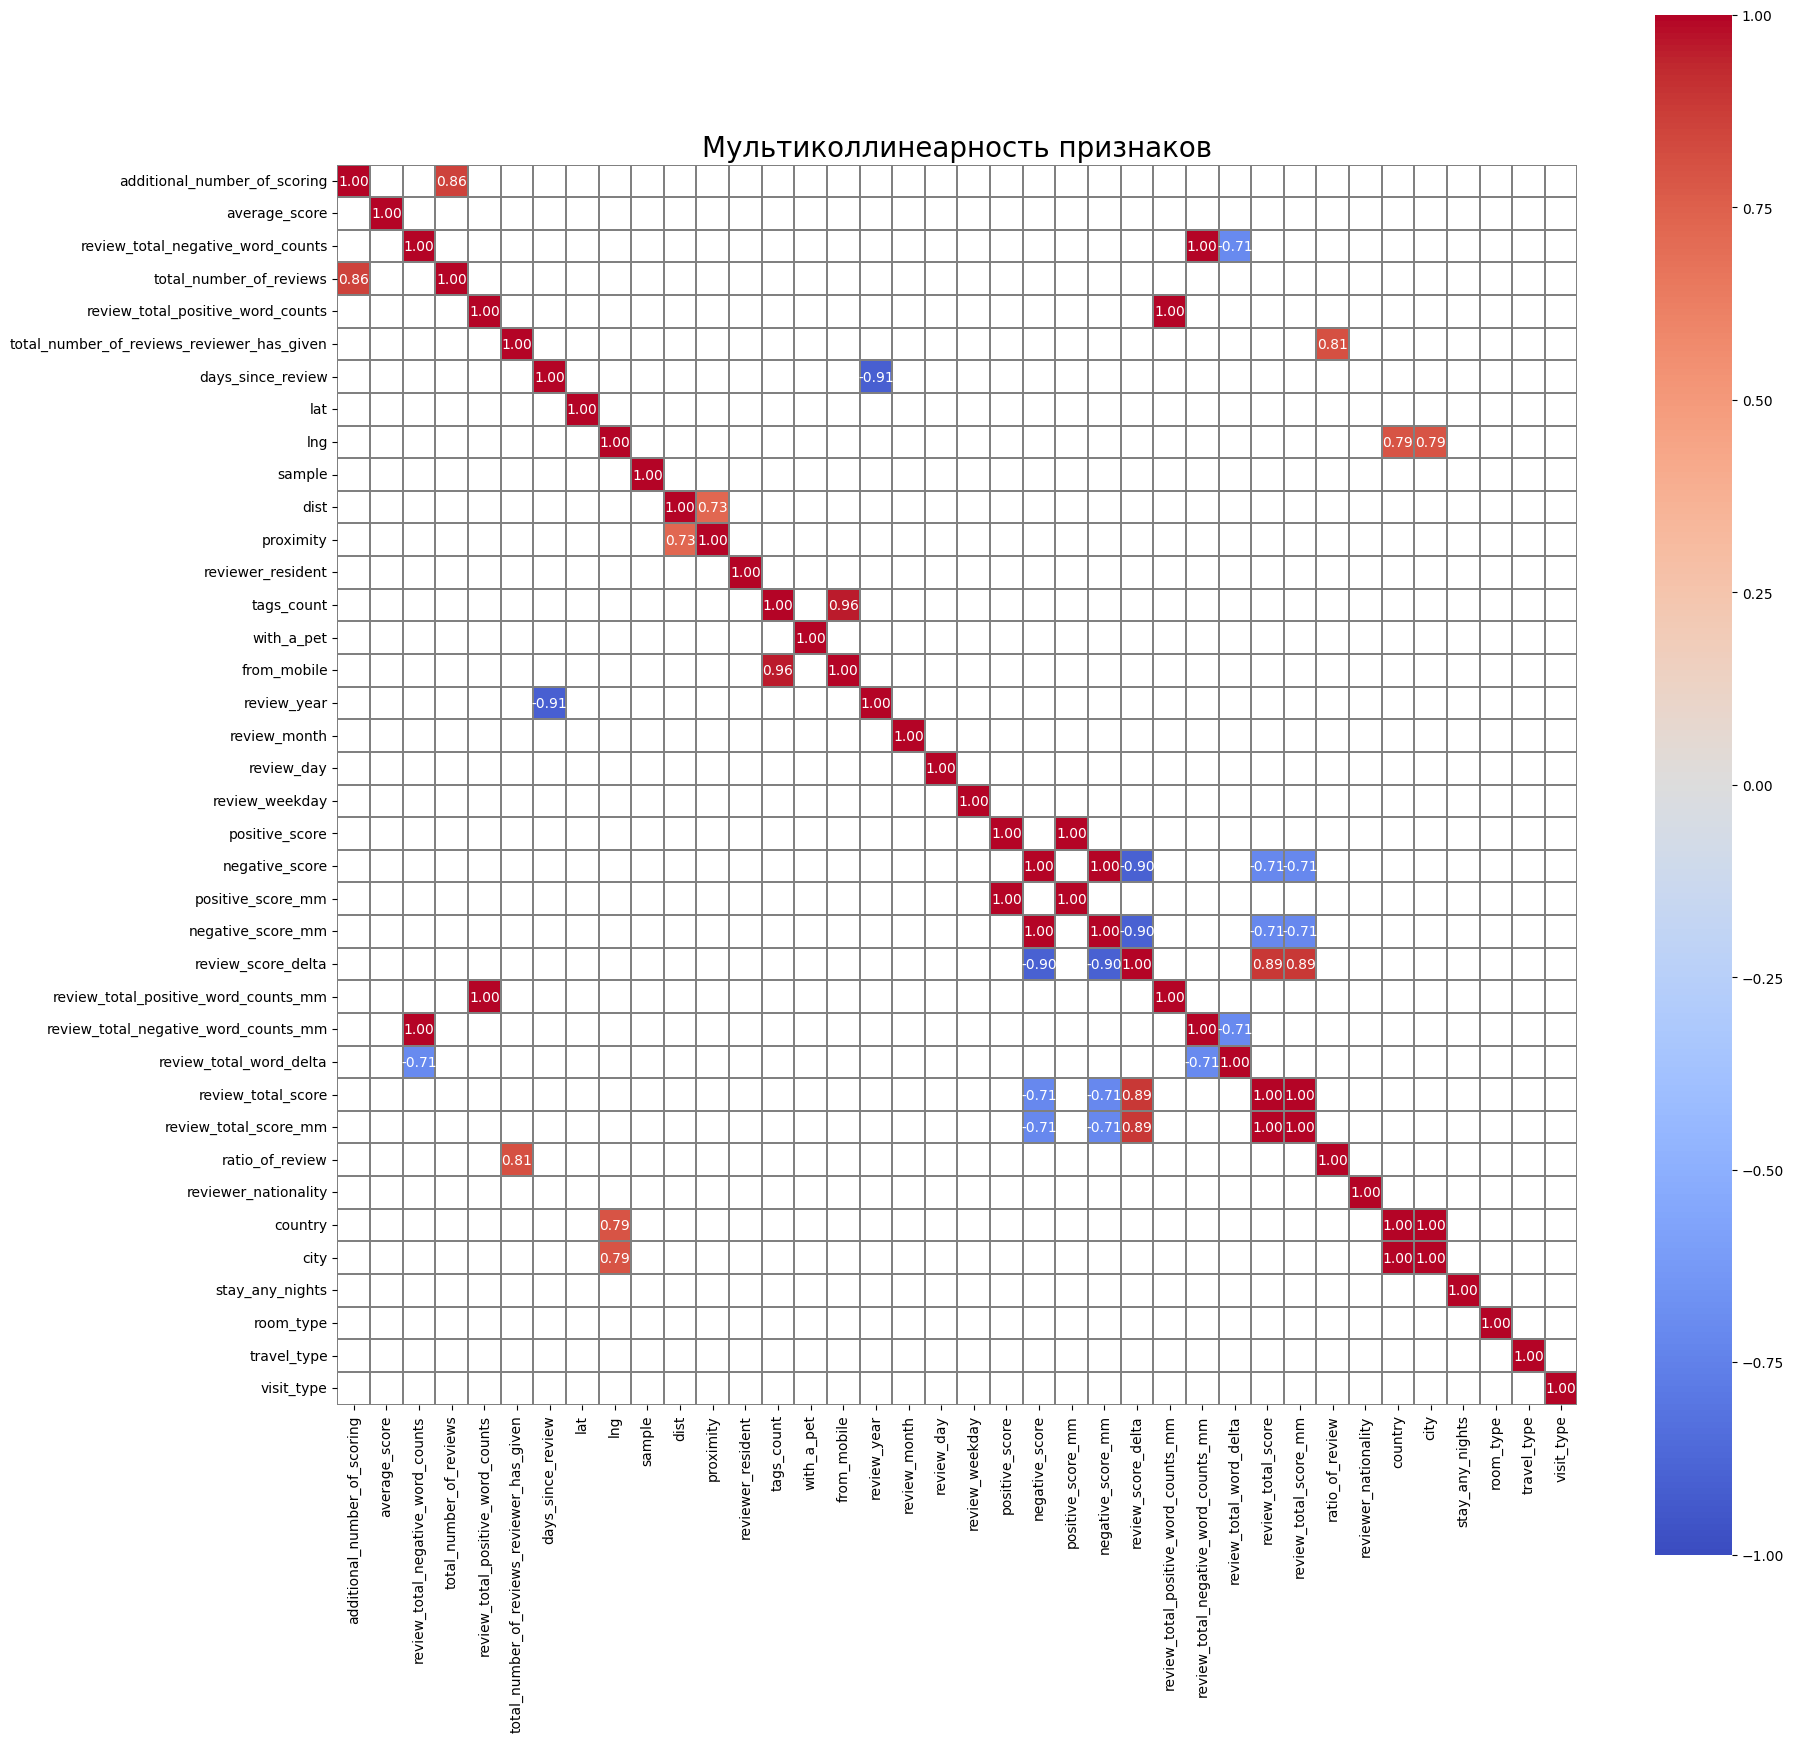

In [106]:
corr = heat_df.drop(['reviewer_score'], axis=1).corr(method='spearman')

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    corr[corr.abs() >= 0.7],
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True) # включаем отображение коэффициентов

# задаём заголовок
ax.set_title('Мультиколлинеарность признаков', fontsize=20);

In [107]:
# создадим список признаков к удалению, исходя из анализа мультиколинеарности

cols_to_del =['lat', 'lng', 'city', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'dist', 'additional_number_of_scoring', 'positive_score', 'negative_score',
              'review_score_delta', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'from_mobile']

In [108]:
heat_df = heat_df.drop(cols_to_del, axis=1)
heat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   average_score                         515738 non-null  float64
 1   reviewer_nationality                  515738 non-null  object 
 2   negative_review                       515738 non-null  object 
 3   total_number_of_reviews               515738 non-null  int64  
 4   positive_review                       515738 non-null  object 
 5   reviewer_score                        515738 non-null  float64
 6   sample                                515738 non-null  int64  
 7   country                               515738 non-null  object 
 8   proximity                             515738 non-null  float64
 9   reviewer_resident                     515738 non-null  int64  
 10  tags_count                            515738 non-null  int64  
 11  

In [109]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
heat_df = heat_df.select_dtypes(exclude=['object'])
heat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   average_score                         515738 non-null  float64
 1   total_number_of_reviews               515738 non-null  int64  
 2   reviewer_score                        515738 non-null  float64
 3   sample                                515738 non-null  int64  
 4   proximity                             515738 non-null  float64
 5   reviewer_resident                     515738 non-null  int64  
 6   tags_count                            515738 non-null  int64  
 7   with_a_pet                            515738 non-null  int64  
 8   review_year                           515738 non-null  int64  
 9   review_month                          515738 non-null  int64  
 10  review_day                            515738 non-null  int64  
 11  

In [110]:
hotels = heat_df.copy()

# Разделение набора данных

Прежде всего, для создания модели необходимо разделить датафрейм на набор данных, которые мы будем использовать для обучения модели, именуемый $X$, и на целевую переменную — величину, значение которой мы будем предсказывать, $y$ (в нашем случае это рейтинг отелей). 

<center> <img src = ../data/dst3-u2-pr3_3_1.png alt="drawing" style="width:600px;">

Далее каждый из полученных наборов мы делим на тренировочный (train, используется для обучения модели) и тестовый (test, используется для оценки точности модели). Такое деление осуществляется с помощью специального метода *train_test_split()* библиотеки *sklearn*. В параметрах метода (параметр test_size) мы указываем, какую часть исходного датафрейма нужно оставить для тестирования модели. В нашем коде эта часть составляет 25 %, или 0.25.

In [114]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
#X = hotels.drop(['reviewer_score'], axis = 1)  
#y = hotels['reviewer_score'] 

In [111]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [112]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [113]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создание и обучение модели

Сам процесс создания и тестирования модели занимает всего четыре строчки кода. В качестве алгоритма мы будем использовать популярный и довольно мощный алгоритм *RandomForestRegressor*. Он реализован в библиотеке *sklearn*.

In [114]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Оценка качества модели

Для оценки качества модели — точности прогнозов, сделанных моделью, — мы будем использовать метрику (некий числовой показатель), которая называется **MAPE (mean absolute percentage error)**, средняя абсолютная процентная ошибка. Эту метрику очень легко интерпретировать. Если *MAPE* = 11.4 %, то это говорит о том, что ошибка составила 11.4 % от фактических значений.

$$ MAPE = 100 \% * 1/n \sum_{i=1}^{n} \frac{\left| ytrue_{i} - ypred_{i} \right|}{\left| ytrue_{i} \right|}, $$

где $ ytrue_{i} $ — фактические значения прогноза, a $ ypred_{i} $ — предсказанные.

Для расчета MAPE сравним предсказанные нашей моделью значения с реальными и посмотрим на значение ошибки.

In [115]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1300914288667286


# История оценки качества модели

Test 1. MAPE: 0.14137455999490872

Test 2. MAPE: 0.14405948022819143

Test 3. MAPE: 0.1301286731351422

Test 4. MAPE: 0.1300914288667286

In [116]:
# округляем результат до десятых долей

for i in range(len(y_pred)):
    y_pred[i] = round(y_pred[i], 1)

y_pred[:10]

array([7.8, 8.9, 7.5, 8.6, 8.7, 8.4, 6.6, 8.7, 4.7, 8.3])

In [118]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [119]:
predict_submission = regr.predict(test_data)

In [120]:
# округляем результат до десятых долей

for i in range(len(predict_submission)):
    predict_submission[i] = round(predict_submission[i], 1)

predict_submission

array([8.5, 7.9, 8. , ..., 8.1, 9.4, 7.2])

In [121]:
list(sample_submission)

['reviewer_score', 'id']

In [122]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.5,488440
1,7.9,274649
2,8.0,374688
3,9.8,404352
4,9.4,451596
5,8.4,302161
6,8.1,317079
7,8.0,13963
8,8.0,159785
9,7.3,195089
